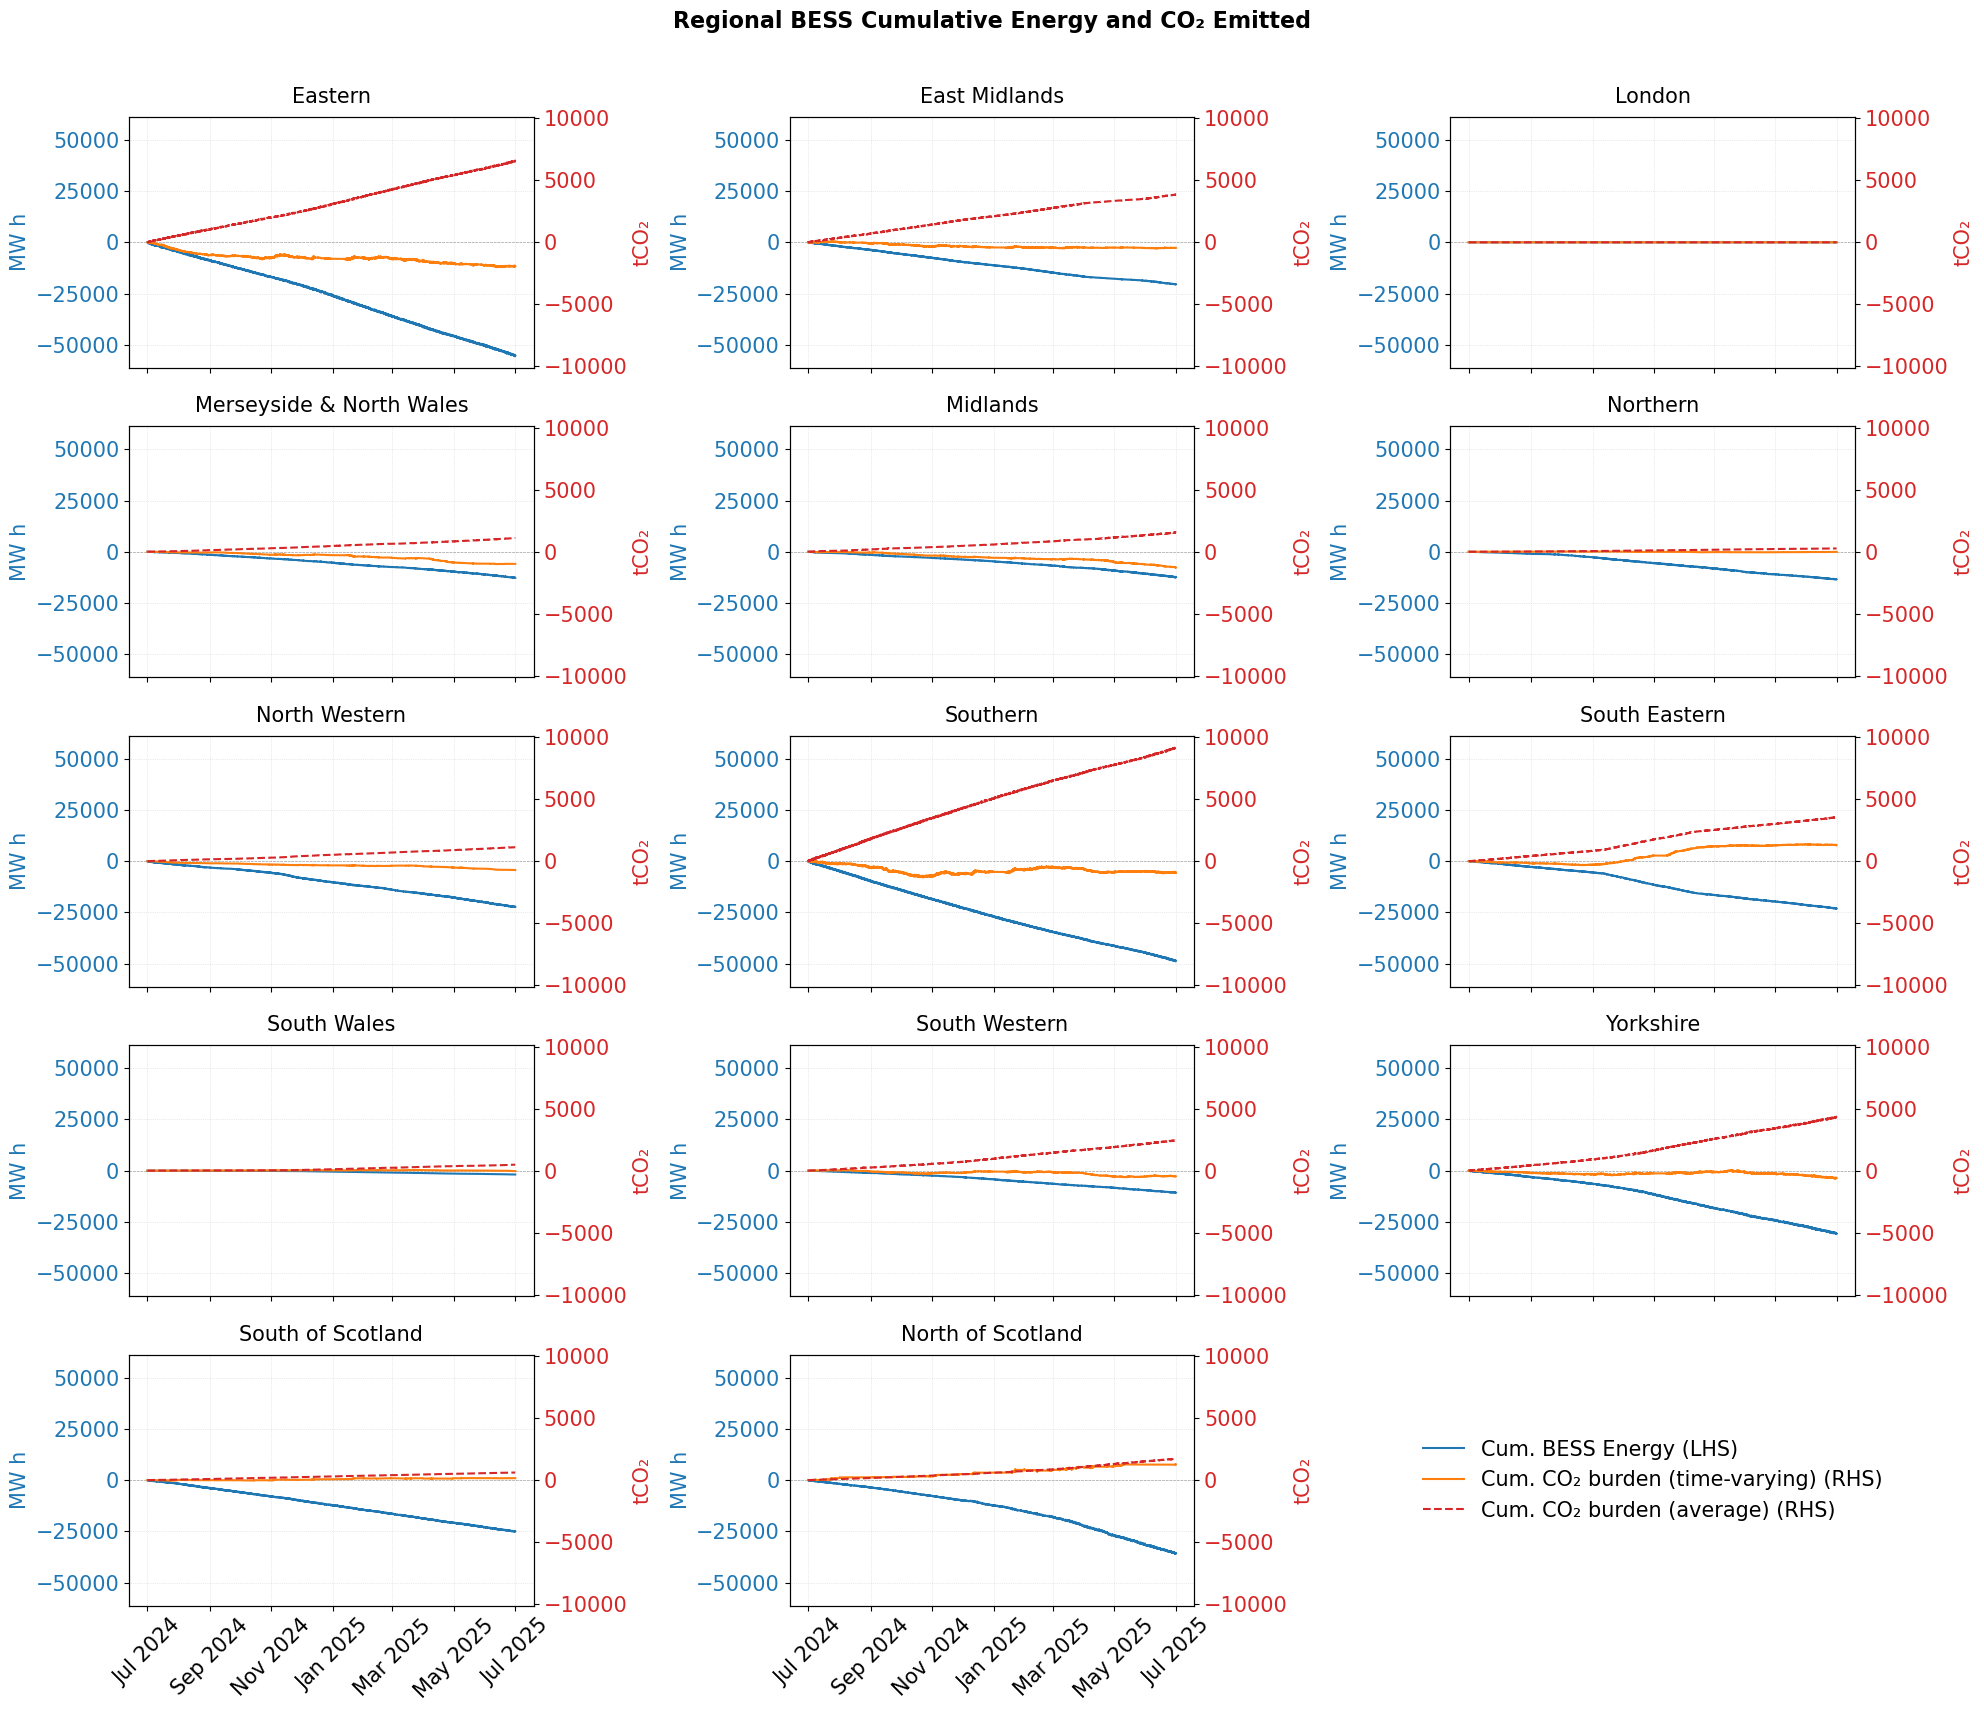

In [8]:
# This outputs 14 subplots of the regional data for cumulative energy and CO2.
# Change: only Cum CO2 (time-varying) flatlines when CI is missing; energy and avg CO2 keep accumulating.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np  # (optional) for safety with NaNs

# === GLOBAL FONT SIZES (min 12) ===
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']

# === Prepare for axis scaling ===
global_energy_max = 0
global_co2_max = 0
region_data = {}

for region in regions:
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        continue

    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()

    # Net energy (independent of CI availability)  ⬅️ CHANGED: no masking by CI
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]

    # Time-varying CO₂: when CI is missing, add 0 so the cumulative line flatlines  ⬅️ CHANGED
    co2_increment_actual = region_df['NetEnergy_MWh'] * region_df[ci_col]
    co2_increment_actual = co2_increment_actual.fillna(0)  # flatline only this series when CI missing
    region_df['CumCO2'] = -(co2_increment_actual.cumsum())/1000  # move from kg to t

    # Cumulative energy keeps going regardless of CI  ⬅️ UNCHANGED in spirit
    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()

    # Average-intensity CO₂: use scalar mean over available CI; if all missing, fall back to 0  ⬅️ CHANGED
    avg_ci = region_df[ci_col].mean(skipna=True)
    if pd.isna(avg_ci):
        avg_ci = 0.0
    region_df['CumCO2_avg'] = -(region_df['NetEnergy_MWh'] * avg_ci).cumsum()/1000  # move from kg to t

    # Track global axis limits safely
    global_energy_max = max(global_energy_max, region_df['CumEnergy'].abs().max(skipna=True))
    global_co2_max = max(
        global_co2_max,
        region_df['CumCO2'].abs().max(skipna=True),
        region_df['CumCO2_avg'].abs().max(skipna=True)
    )

    region_data[region] = region_df

# === Set axis limits based on global maxes ===
energy_lim = (-global_energy_max * 1.1, global_energy_max * 1.1)
co2_lim = (-global_co2_max * 1.1, global_co2_max * 1.1)

# === Set up plot grid ===
fig, axes = plt.subplots(5, 3, figsize=(20, 18), sharex=True)
axes = axes.flatten()

# === Collect one copy of each line style for the global legend ===
legend_handles = []

for i, region in enumerate(regions):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    if region not in region_data:
        ax1.set_visible(False)
        continue

    region_df = region_data[region]

    # === Plot energy ===
    line1, = ax1.plot(region_df['datetime'], region_df['CumEnergy'],
                      color='tab:blue', linewidth=1.5)
    ax1.set_ylim(energy_lim)
    ax1.set_ylabel("MW h", color='tab:blue', fontsize=15)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=15)

    # === Plot CO₂ burden (actual) ===
    line2, = ax2.plot(region_df['datetime'], region_df['CumCO2'],
                      color='tab:orange', linewidth=1.5)

    # === Plot CO₂ burden (average) ===
    line3, = ax2.plot(region_df['datetime'], region_df['CumCO2_avg'],
                      color='tab:red', linestyle='--', linewidth=1.5)

    ax2.set_ylim(co2_lim)
    ax2.set_ylabel("tCO\u2082", color='tab:red', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=15)

    # === Formatting ===
    region_descriptions = {
        '_A': 'Eastern',
        '_B': 'East Midlands',
        '_C': 'London',
        '_D': 'Merseyside & North Wales',
        '_E': 'Midlands',
        '_F': 'Northern',
        '_G': 'North Western',
        '_H': 'Southern',
        '_J': 'South Eastern',
        '_K': 'South Wales',
        '_L': 'South Western',
        '_M': 'Yorkshire',
        '_N': 'South of Scotland',
        '_P': 'North of Scotland'
    }
    ax1.set_title(region_descriptions.get(region, region), fontsize=15, pad=10)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.tick_params(axis='x', labelrotation=45, labelsize=15)
    ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)
    ax1.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

    # Save first instance of legend handles
    if not legend_handles:
        legend_handles = [
            (line1, "Cum. BESS Energy (LHS)"),
            (line2, "Cum. CO₂ burden (time-varying) (RHS)"),
            (line3, "Cum. CO₂ burden (average) (RHS)")
        ]

# === Hide and use final subplot for legend ===
if len(regions) < len(axes):
    axes[-1].axis('off')
    handles, labels = zip(*legend_handles)
    axes[-1].legend(handles, labels, loc='center', fontsize=15, frameon=False)

# === Title and layout ===
fig.suptitle("Regional BESS Cumulative Energy and CO₂ Emitted", fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


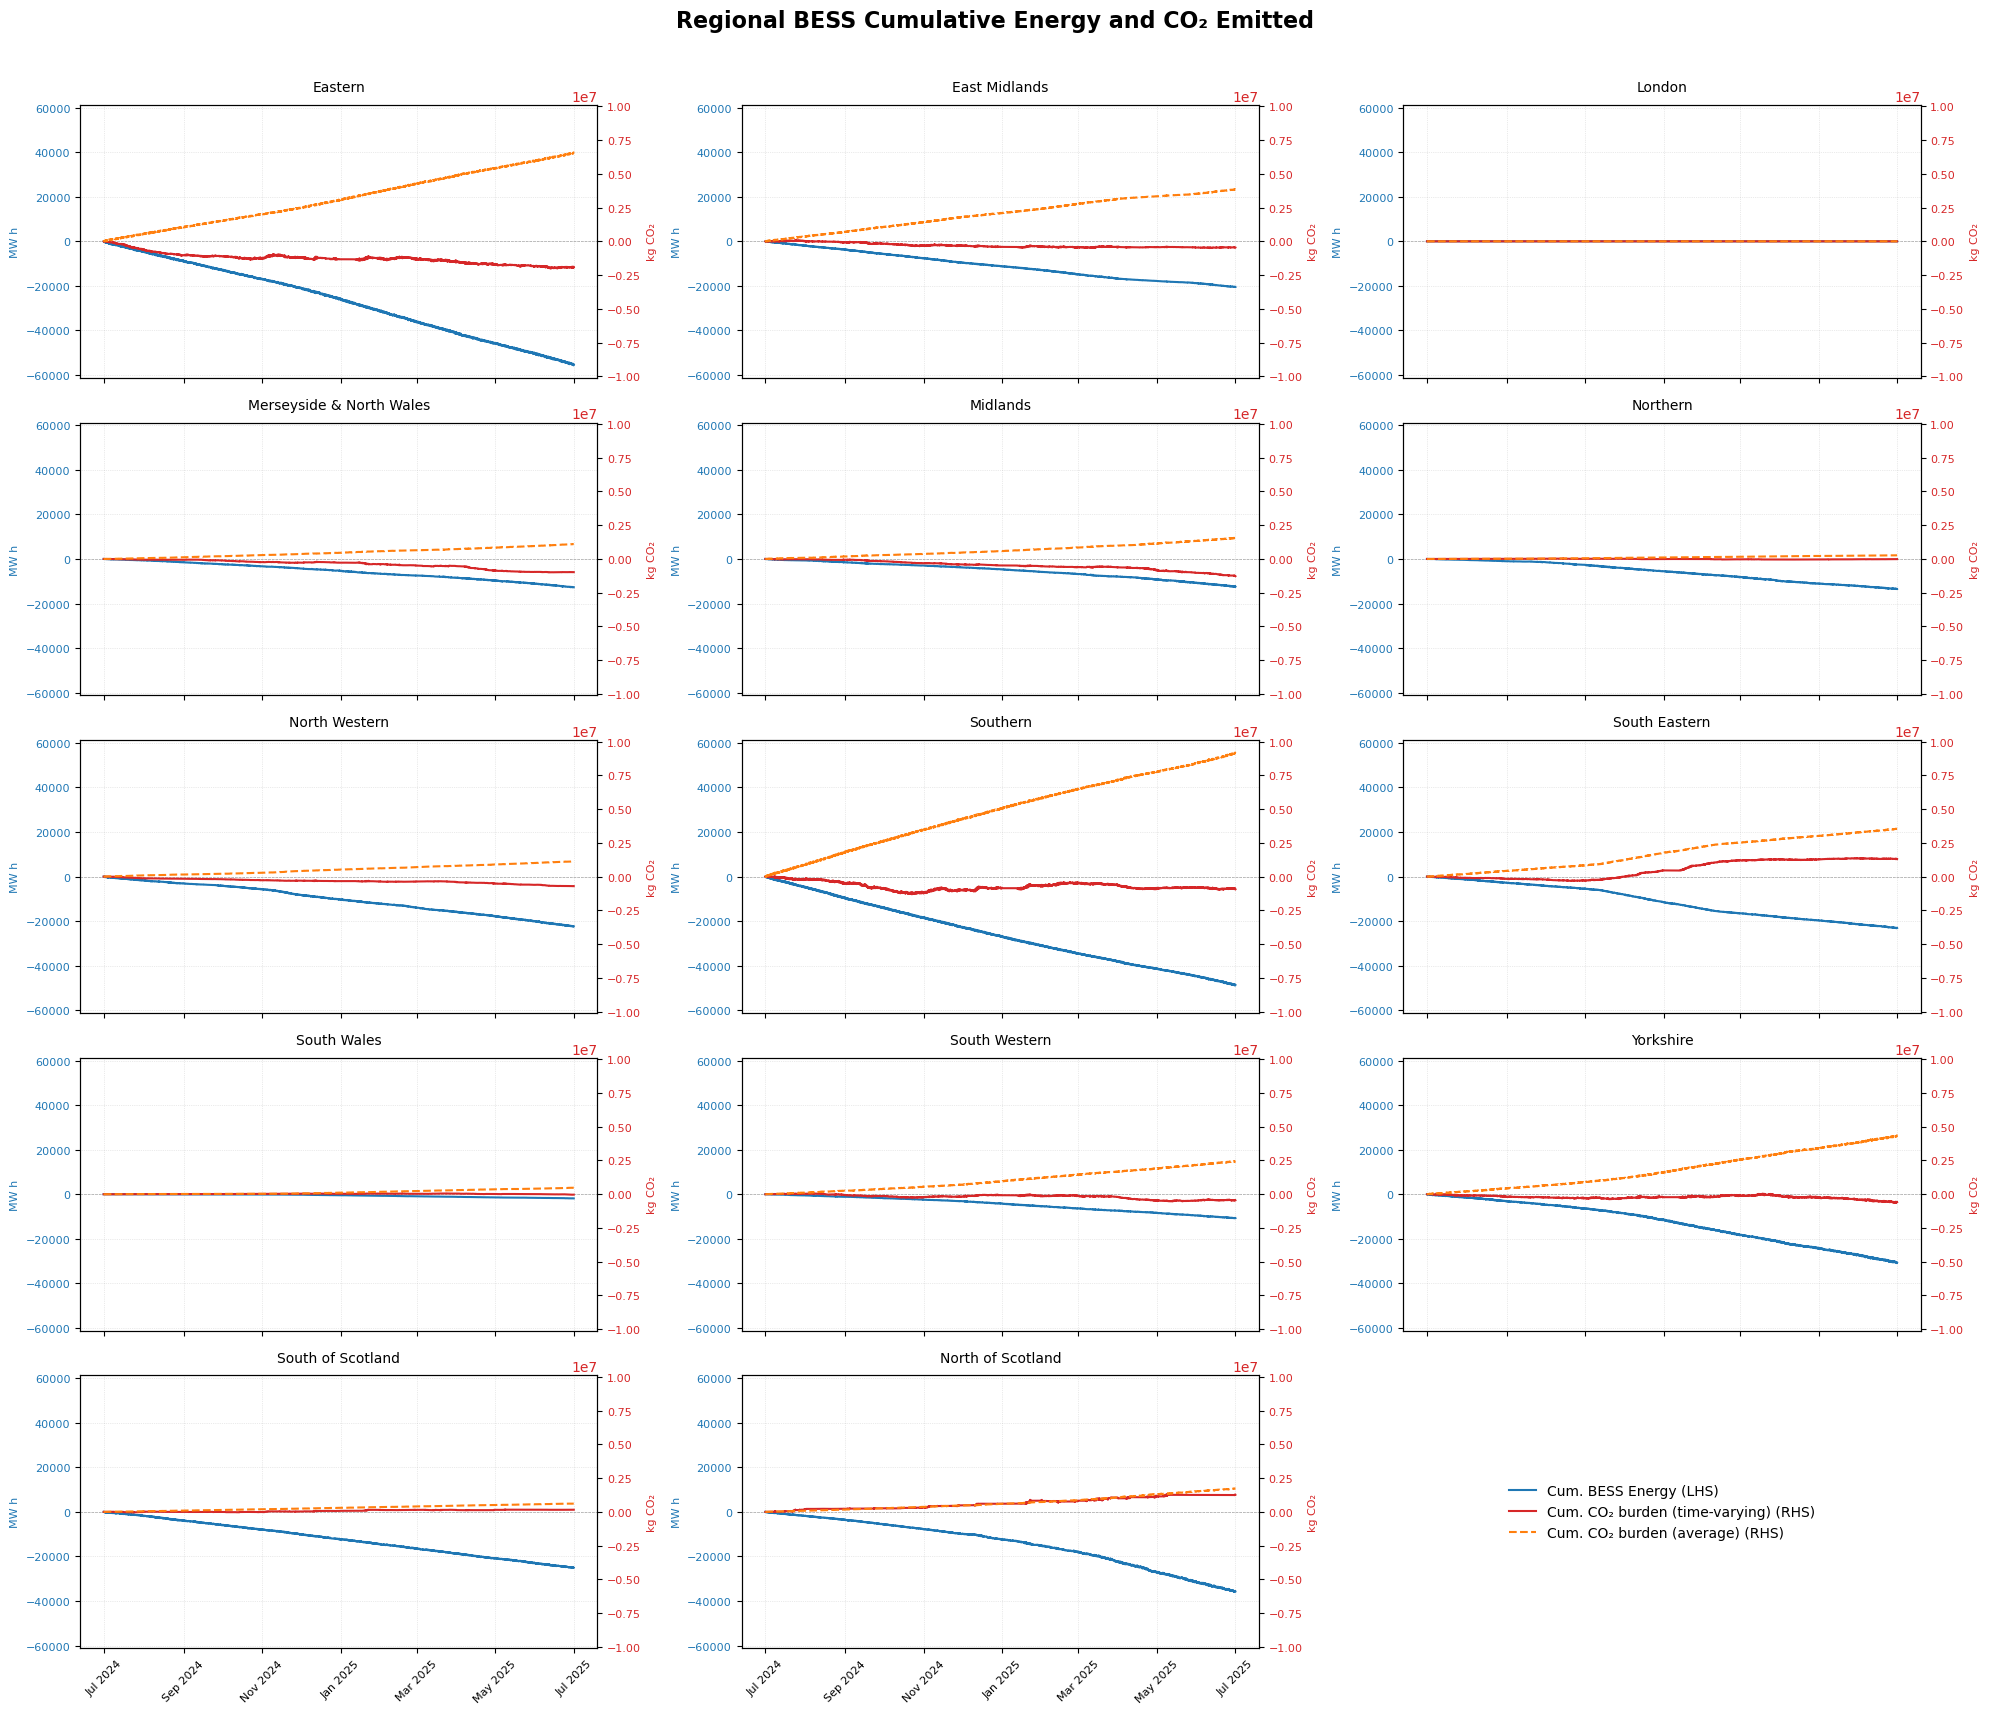

In [1]:
# This outputs 14 subplots of the regional data for cumulative energy and CO2.
# Change: only Cum CO2 (time-varying) flatlines when CI is missing; energy and avg CO2 keep accumulating.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np  # (optional) for safety with NaNs

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']

# === Prepare for axis scaling ===
global_energy_max = 0
global_co2_max = 0
region_data = {}

for region in regions:
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        continue

    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()

    # Net energy (independent of CI availability)  ⬅️ CHANGED: no masking by CI
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]

    # Time-varying CO₂: when CI is missing, add 0 so the cumulative line flatlines  ⬅️ CHANGED
    co2_increment_actual = region_df['NetEnergy_MWh'] * region_df[ci_col]
    co2_increment_actual = co2_increment_actual.fillna(0)  # flatline only this series when CI missing
    region_df['CumCO2'] = -(co2_increment_actual.cumsum())  # keep your sign convention

    # Cumulative energy keeps going regardless of CI  ⬅️ UNCHANGED in spirit
    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()

    # Average-intensity CO₂: use scalar mean over available CI; if all missing, fall back to 0  ⬅️ CHANGED
    avg_ci = region_df[ci_col].mean(skipna=True)
    if pd.isna(avg_ci):
        avg_ci = 0.0
    region_df['CumCO2_avg'] = -(region_df['NetEnergy_MWh'] * avg_ci).cumsum()

    # Track global axis limits safely
    global_energy_max = max(global_energy_max, region_df['CumEnergy'].abs().max(skipna=True))
    global_co2_max = max(
        global_co2_max,
        region_df['CumCO2'].abs().max(skipna=True),
        region_df['CumCO2_avg'].abs().max(skipna=True)
    )

    region_data[region] = region_df

# === Set axis limits based on global maxes ===
energy_lim = (-global_energy_max * 1.1, global_energy_max * 1.1)
co2_lim = (-global_co2_max * 1.1, global_co2_max * 1.1)

# === Set up plot grid ===
fig, axes = plt.subplots(5, 3, figsize=(20, 18), sharex=True)
axes = axes.flatten()

# === Collect one copy of each line style for the global legend ===
legend_handles = []

for i, region in enumerate(regions):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    if region not in region_data:
        ax1.set_visible(False)
        continue

    region_df = region_data[region]

    # === Plot energy ===
    line1, = ax1.plot(region_df['datetime'], region_df['CumEnergy'],
                      color='tab:blue', linewidth=1.5)
    ax1.set_ylim(energy_lim)
    ax1.set_ylabel("MW h", color='tab:blue', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)

    # === Plot CO₂ burden (actual) ===
    line2, = ax2.plot(region_df['datetime'], region_df['CumCO2'],
                      color='tab:red', linewidth=1.5)

    # === Plot CO₂ burden (average) ===
    line3, = ax2.plot(region_df['datetime'], region_df['CumCO2_avg'],
                      color='tab:orange', linestyle='--', linewidth=1.5)

    ax2.set_ylim(co2_lim)
    ax2.set_ylabel("kg CO\u2082", color='tab:red', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=8)

    # === Formatting ===
    region_descriptions = {
        '_A': 'Eastern',
        '_B': 'East Midlands',
        '_C': 'London',
        '_D': 'Merseyside & North Wales',
        '_E': 'Midlands',
        '_F': 'Northern',
        '_G': 'North Western',
        '_H': 'Southern',
        '_J': 'South Eastern',
        '_K': 'South Wales',
        '_L': 'South Western',
        '_M': 'Yorkshire',
        '_N': 'South of Scotland',
        '_P': 'North of Scotland'
    }
    ax1.set_title(region_descriptions.get(region, region), fontsize=10, pad=10)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)
    ax1.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

    # Save first instance of legend handles
    if not legend_handles:
        legend_handles = [
            (line1, "Cum. BESS Energy (LHS)"),
            (line2, "Cum. CO₂ burden (time-varying) (RHS)"),
            (line3, "Cum. CO₂ burden (average) (RHS)")
        ]

# === Hide and use final subplot for legend ===
if len(regions) < len(axes):
    axes[-1].axis('off')
    handles, labels = zip(*legend_handles)
    axes[-1].legend(handles, labels, loc='center', fontsize=10, frameon=False)

# === Title and layout ===
fig.suptitle("Regional BESS Cumulative Energy and CO₂ Emitted", fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


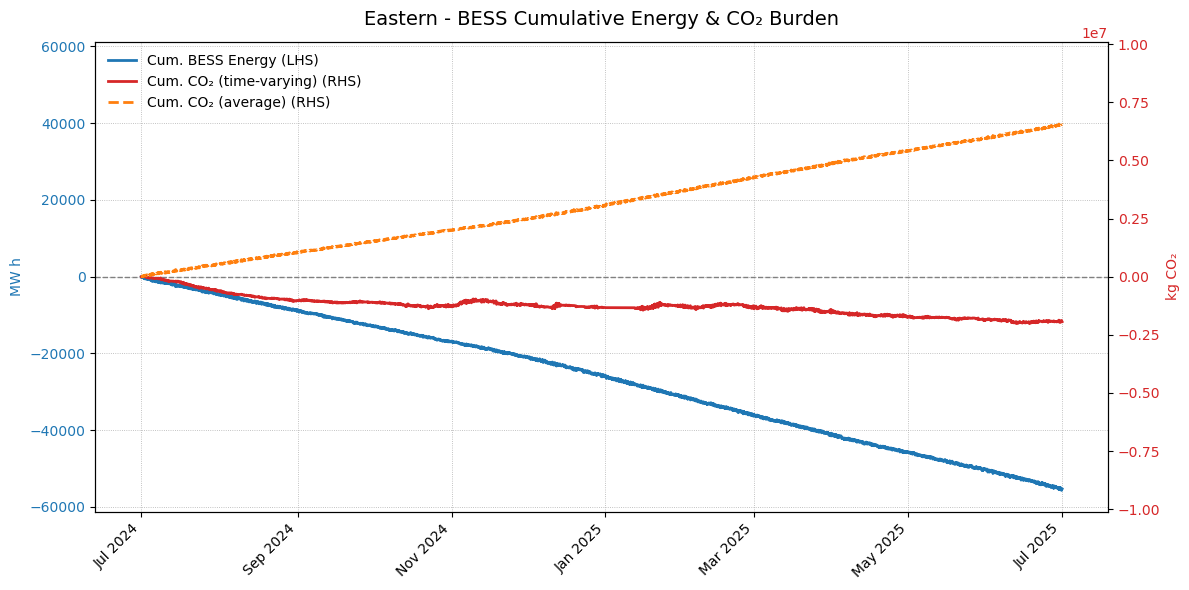

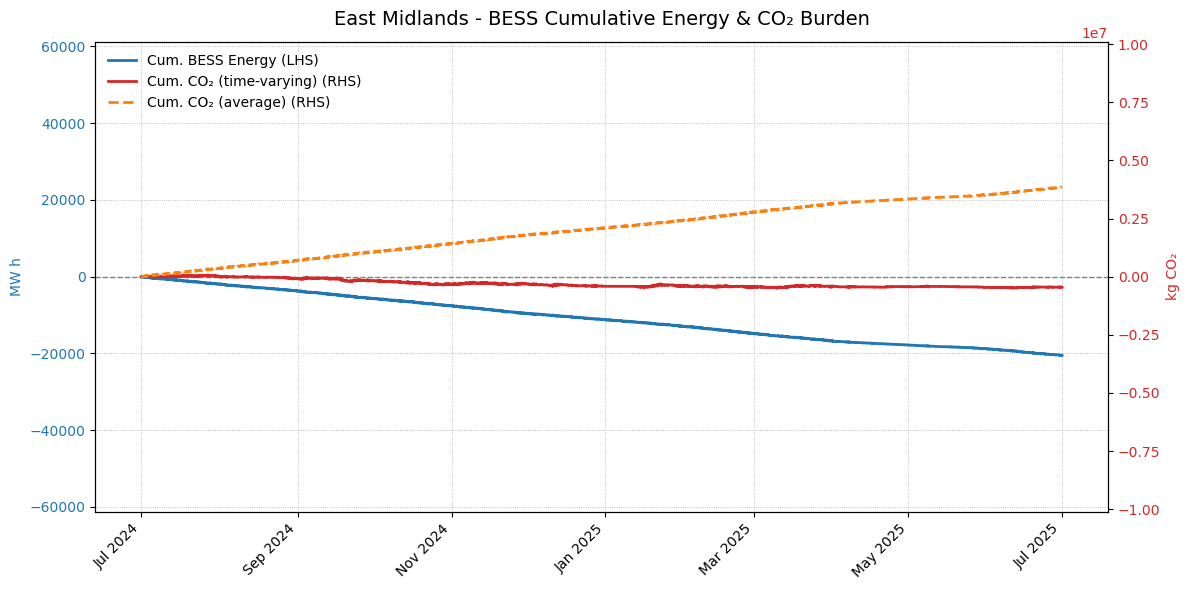

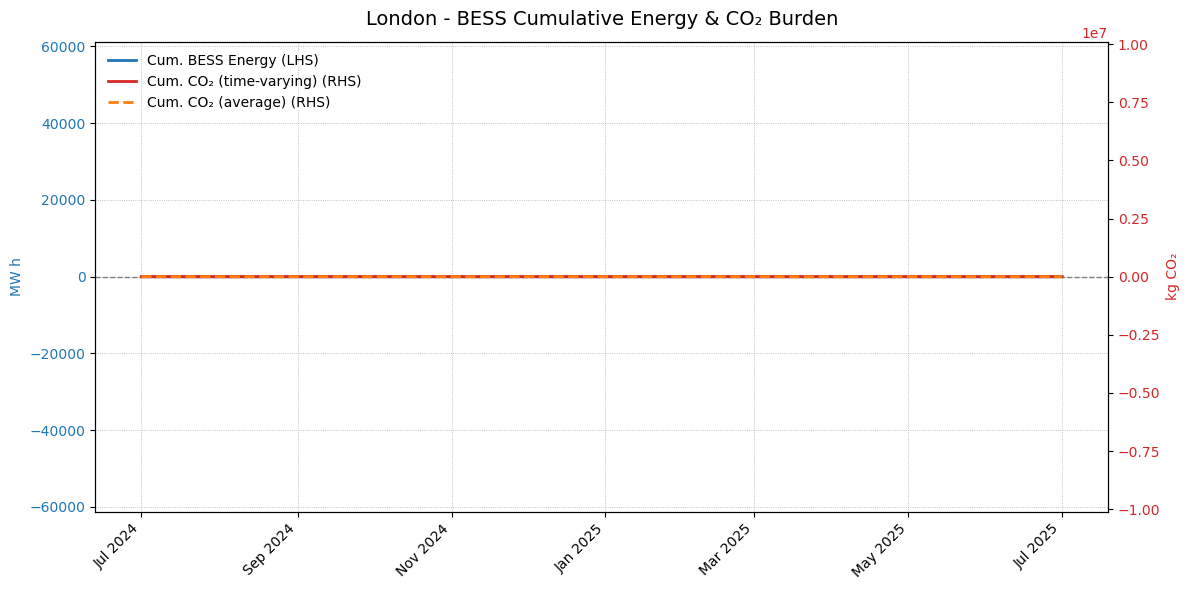

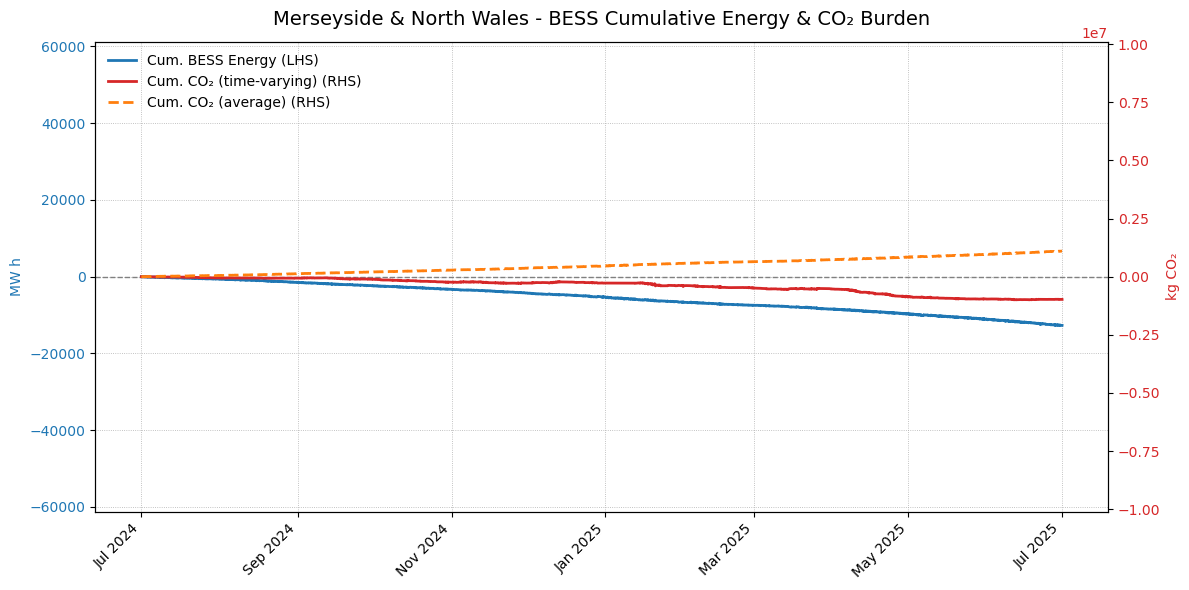

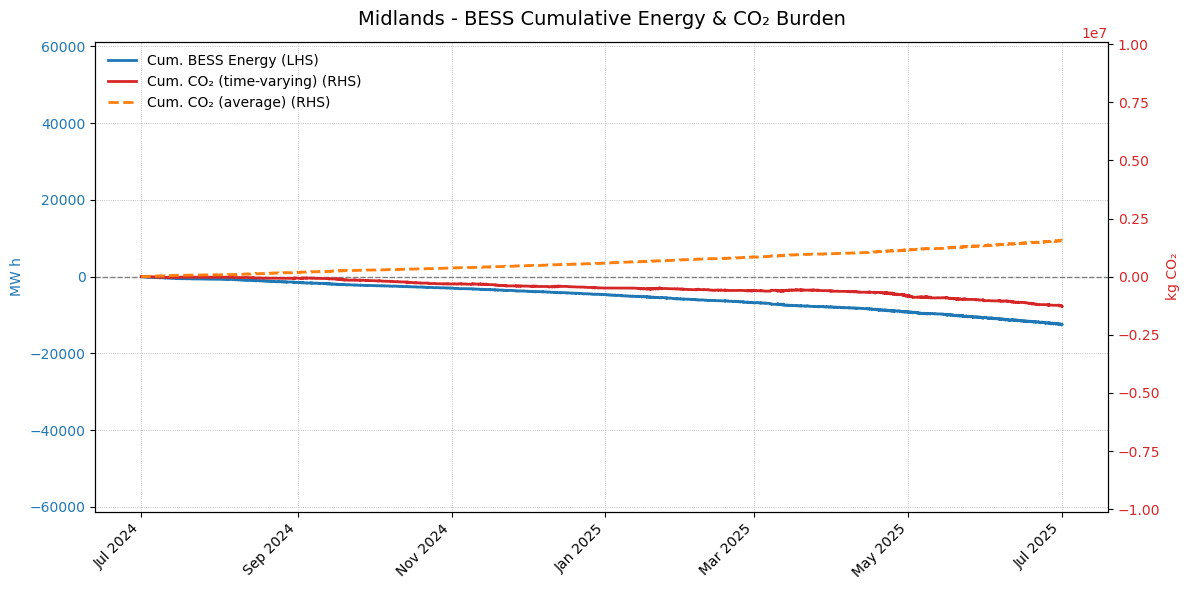

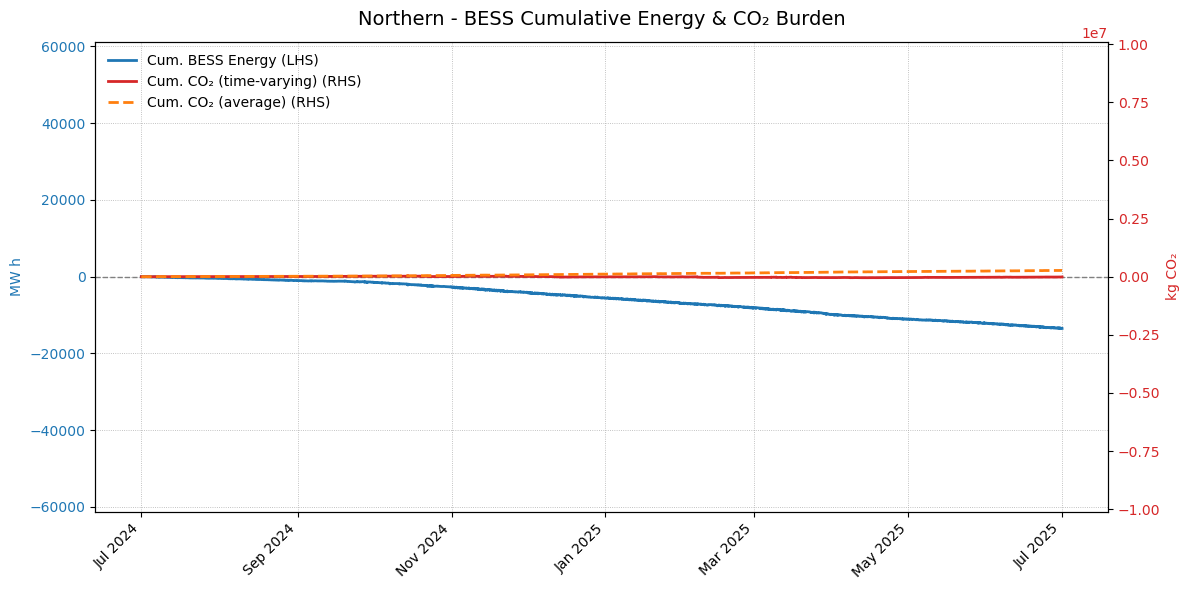

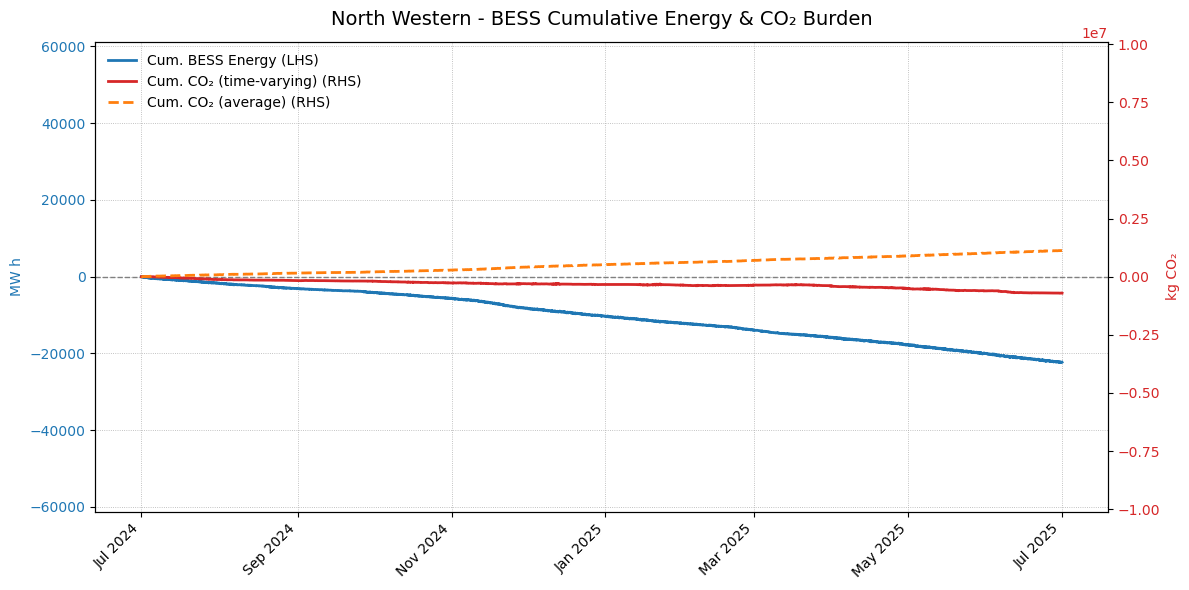

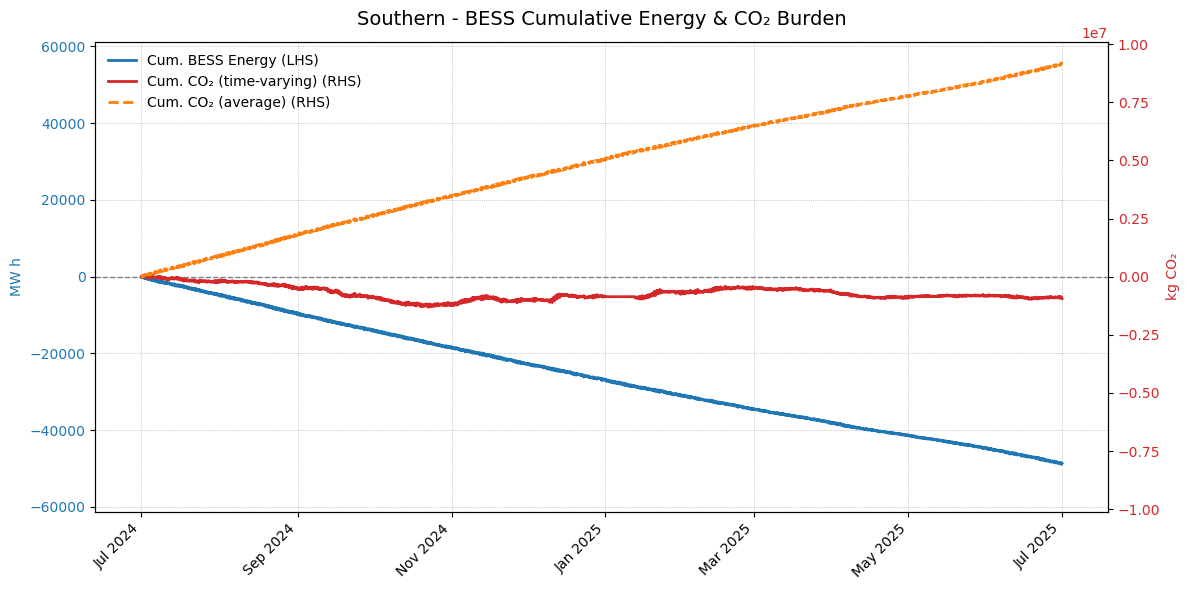

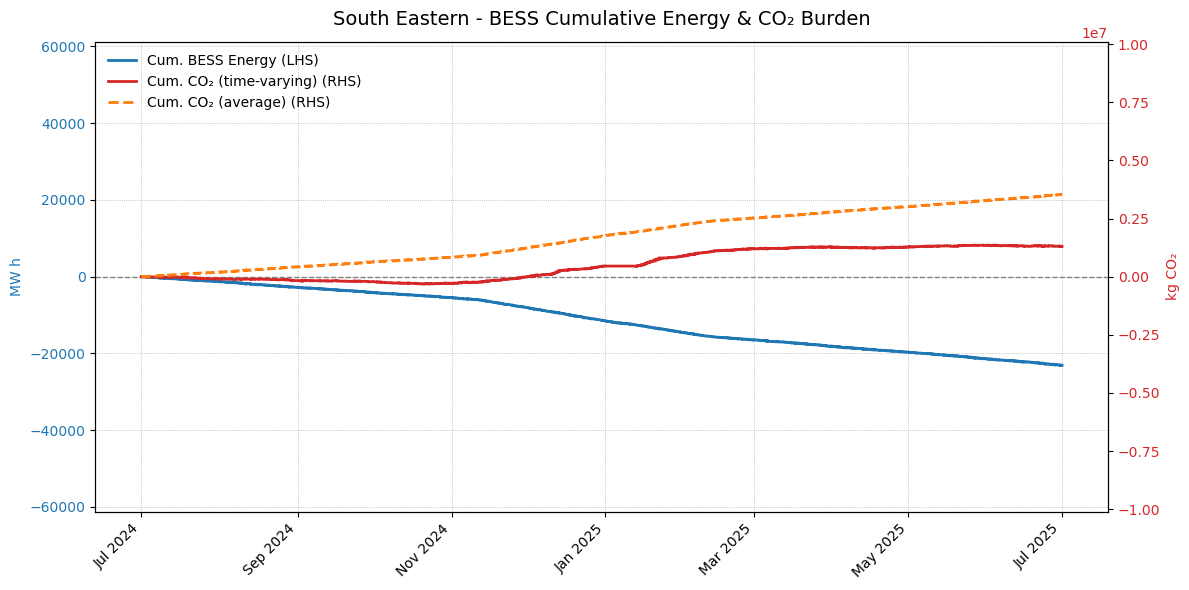

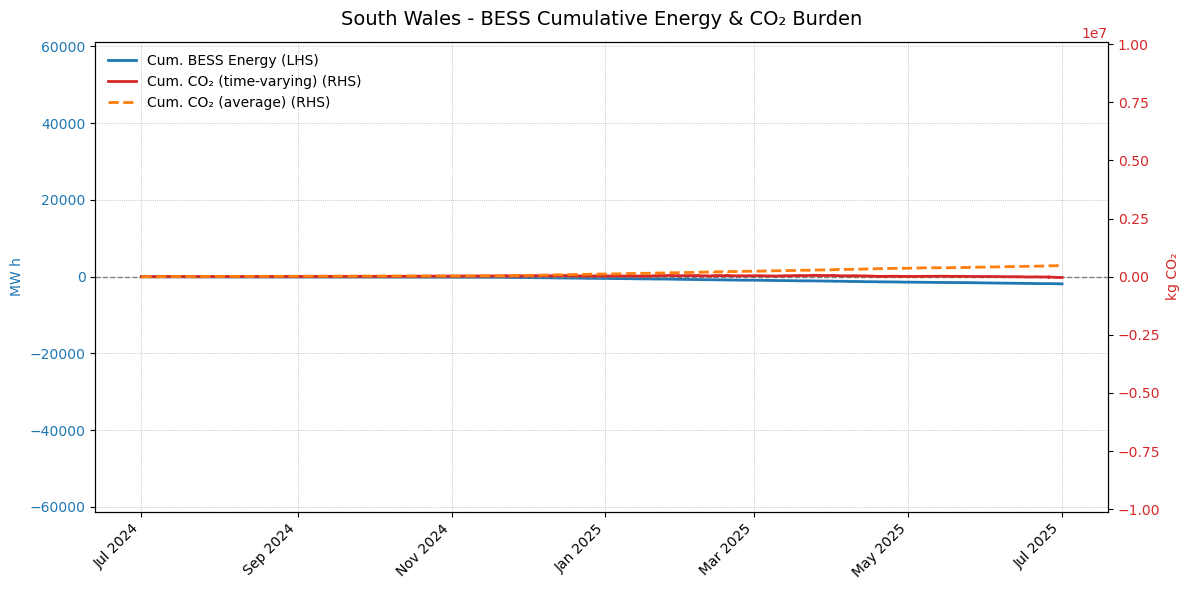

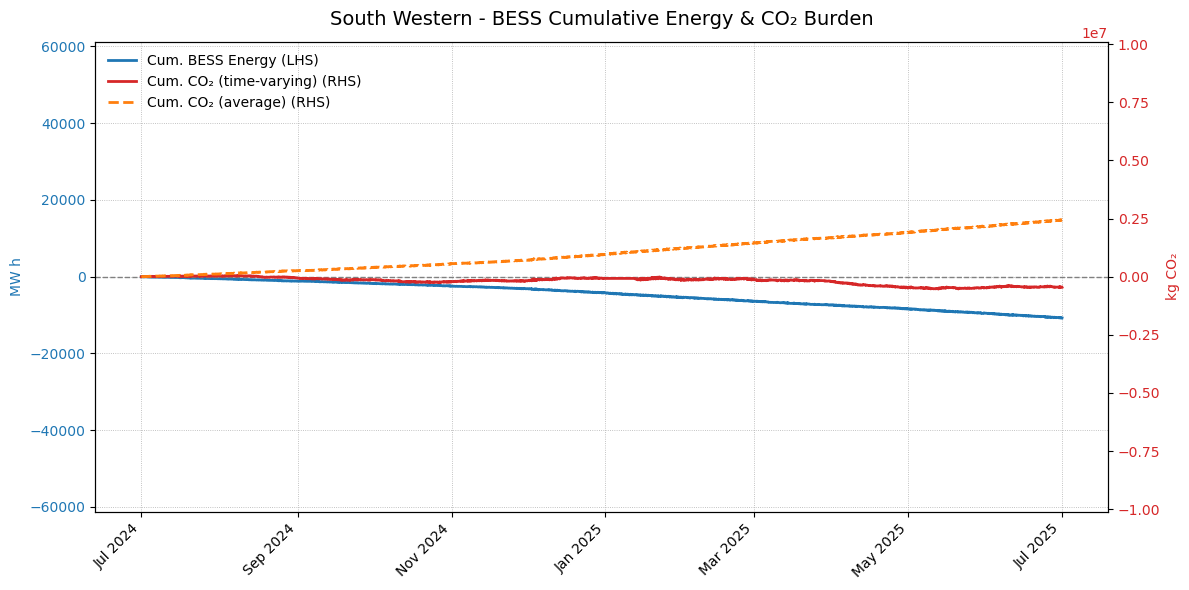

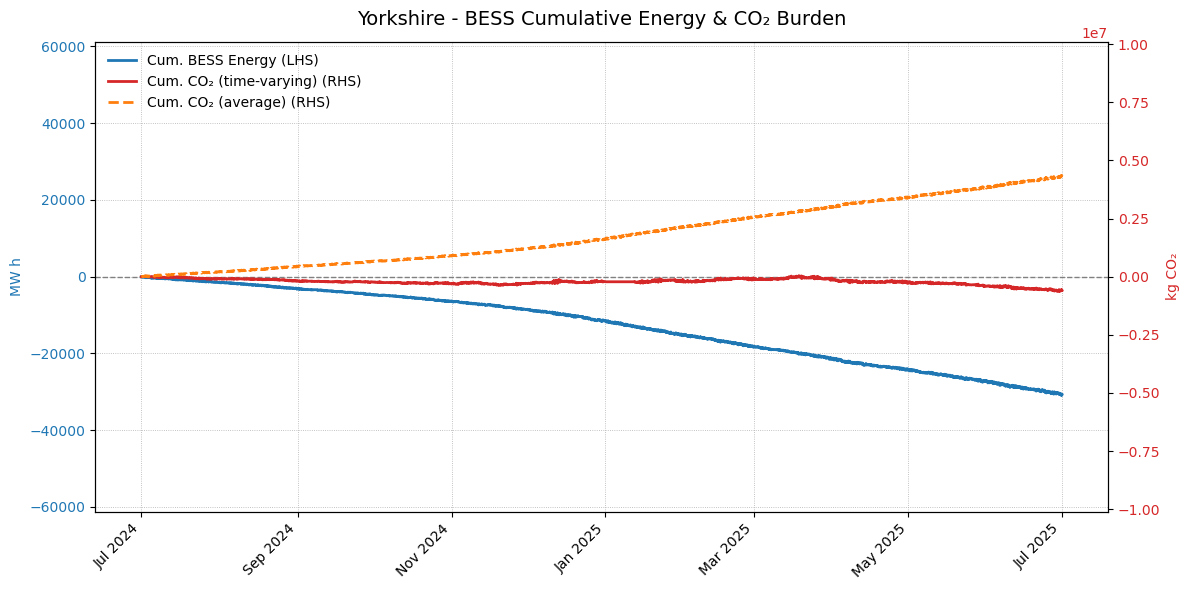

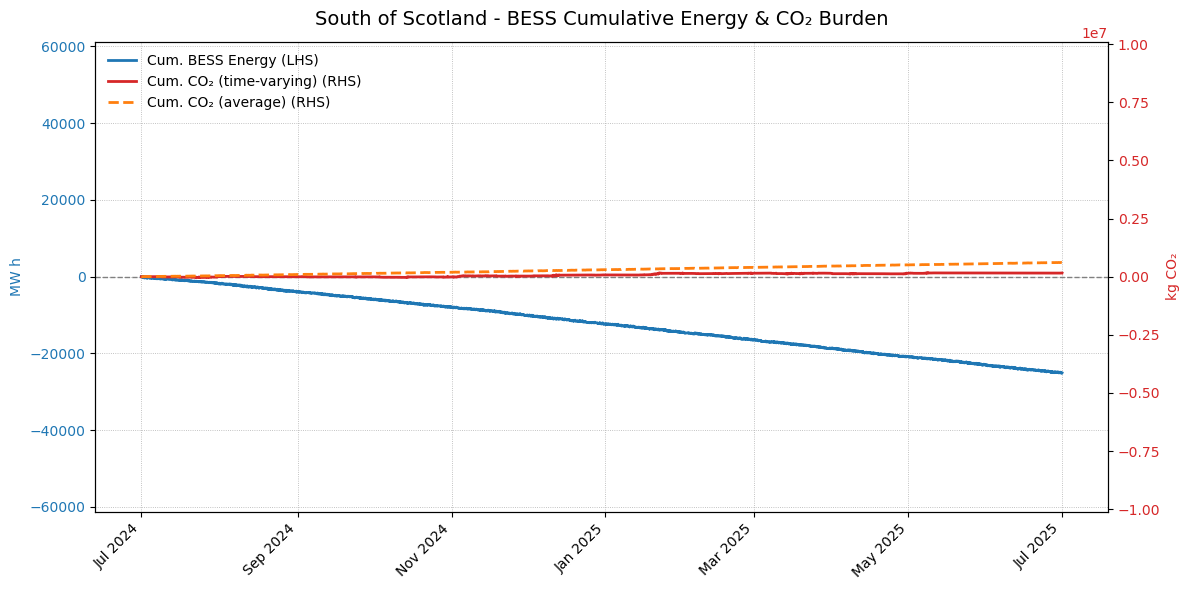

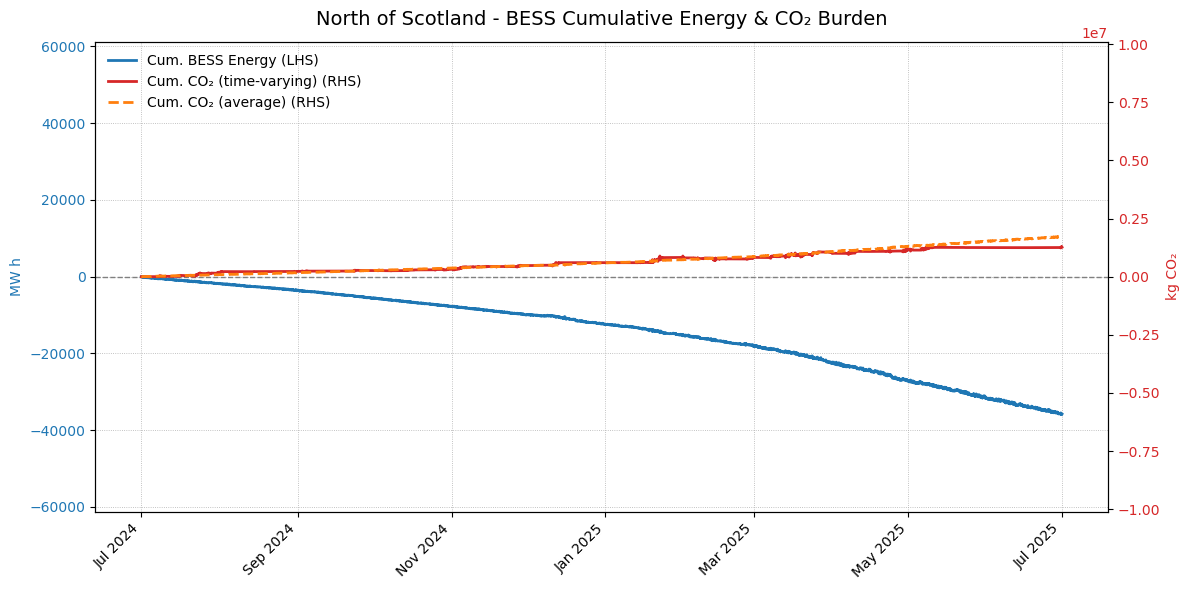


=== Summary Table ===
                  Region  Cum. BESS Energy (MW h)  Cum. CO2 (time-varying) (kg)  Cum. CO2 (average) (kg)
                 Eastern               -55248.811                 -1.938362e+06             6.538912e+06
           East Midlands               -20490.679                 -4.565078e+05             3.844277e+06
                  London                    0.000                 -0.000000e+00            -0.000000e+00
Merseyside & North Wales               -12680.411                 -9.765671e+05             1.100391e+06
                Midlands               -12404.681                 -1.273489e+06             1.552963e+06
                Northern               -13483.213                 -9.207972e+03             2.712602e+05
           North Western               -22278.041                 -7.058773e+05             1.124485e+06
                Southern               -48604.982                 -9.421158e+05             9.132491e+06
           South Eastern        

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes and descriptions ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern',
    '_B': 'East Midlands',
    '_C': 'London',
    '_D': 'Merseyside & North Wales',
    '_E': 'Midlands',
    '_F': 'Northern',
    '_G': 'North Western',
    '_H': 'Southern',
    '_J': 'South Eastern',
    '_K': 'South Wales',
    '_L': 'South Western',
    '_M': 'Yorkshire',
    '_N': 'South of Scotland',
    '_P': 'North of Scotland'
}

# === Prepare for axis scaling and summary table ===
global_energy_max = 0
global_co2_max = 0
region_data = []
summary_data = []

# === Loop through regions to compute data and get axis bounds ===
for region in regions:
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        continue

    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()

    # Net energy should NOT depend on CI availability  ⬅️ CHANGED
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]

    # Time-varying CO₂: when CI is missing, add 0 (flatline only this series)  ⬅️ CHANGED
    co2_inc_actual = region_df['NetEnergy_MWh'] * region_df[ci_col]
    co2_inc_actual = co2_inc_actual.fillna(0.0)
    region_df['CumCO2'] = -(co2_inc_actual.cumsum())

    # Cumulative energy continues regardless of CI  ⬅️ CHANGED (no masking)
    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()

    # Average CO₂: scalar mean over available CI, fallback 0 if all missing  ⬅️ CHANGED
    avg_ci = region_df[ci_col].mean(skipna=True)
    if pd.isna(avg_ci):
        avg_ci = 0.0
    region_df['CumCO2_avg'] = -(region_df['NetEnergy_MWh'] * avg_ci).cumsum()

    # Track axis bounds
    global_energy_max = max(global_energy_max, region_df['CumEnergy'].abs().max(skipna=True))
    global_co2_max = max(
        global_co2_max,
        region_df['CumCO2'].abs().max(skipna=True),
        region_df['CumCO2_avg'].abs().max(skipna=True)
    )

    # Add to summary (safe even if last rows had missing CI)
    final_row = region_df.iloc[-1]
    summary_data.append({
        "Region": region_descriptions.get(region, region),
        "Cum. BESS Energy (MW h)": final_row['CumEnergy'],
        "Cum. CO2 (time-varying) (kg)": final_row['CumCO2'],
        "Cum. CO2 (average) (kg)": final_row['CumCO2_avg']
    })

    # Store for plotting
    region_data.append((region_descriptions[region], region_df))

# === Axis limits ===
energy_lim = (-global_energy_max * 1.1, global_energy_max * 1.1)
co2_lim = (-global_co2_max * 1.1, global_co2_max * 1.1)

# === Plot individual charts ===
for name, region_df in region_data:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    # Plot Energy
    line1, = ax1.plot(region_df['datetime'], region_df['CumEnergy'], color='tab:blue', linewidth=2, label="Cum. BESS Energy (LHS)")
    ax1.set_ylabel("MW h", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(energy_lim)

    # Plot CO2 actual and average
    line2, = ax2.plot(region_df['datetime'], region_df['CumCO2'], color='tab:red', linewidth=2, label="Cum. CO₂ (time-varying) (RHS)")
    line3, = ax2.plot(region_df['datetime'], region_df['CumCO2_avg'], color='tab:orange', linestyle='--', linewidth=2, label="Cum. CO₂ (average) (RHS)")
    ax2.set_ylabel("kg CO\u2082", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(co2_lim)

    # Format
    ax1.set_title(f"{name} - BESS Cumulative Energy & CO₂ Burden", fontsize=14, pad=12)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax1.grid(True, linestyle=':', linewidth=0.6)

    # Legend
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10, frameon=False)

    plt.tight_layout()
    plt.show()

# === Output summary table ===
summary_df = pd.DataFrame(summary_data)
totals = summary_df.drop(columns="Region").sum(numeric_only=True)
totals["Region"] = "TOTAL"
summary_df = pd.concat([summary_df, pd.DataFrame([totals])], ignore_index=True)

print("\n=== Summary Table ===")
print(summary_df.to_string(index=False))

# Optional CSV export:
# summary_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\regional_cumulative_summary.csv"
# summary_df.to_csv(summary_path, index=False)


In [3]:
summary_df.to_csv(r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\regional_bess_summary.csv", index=False)

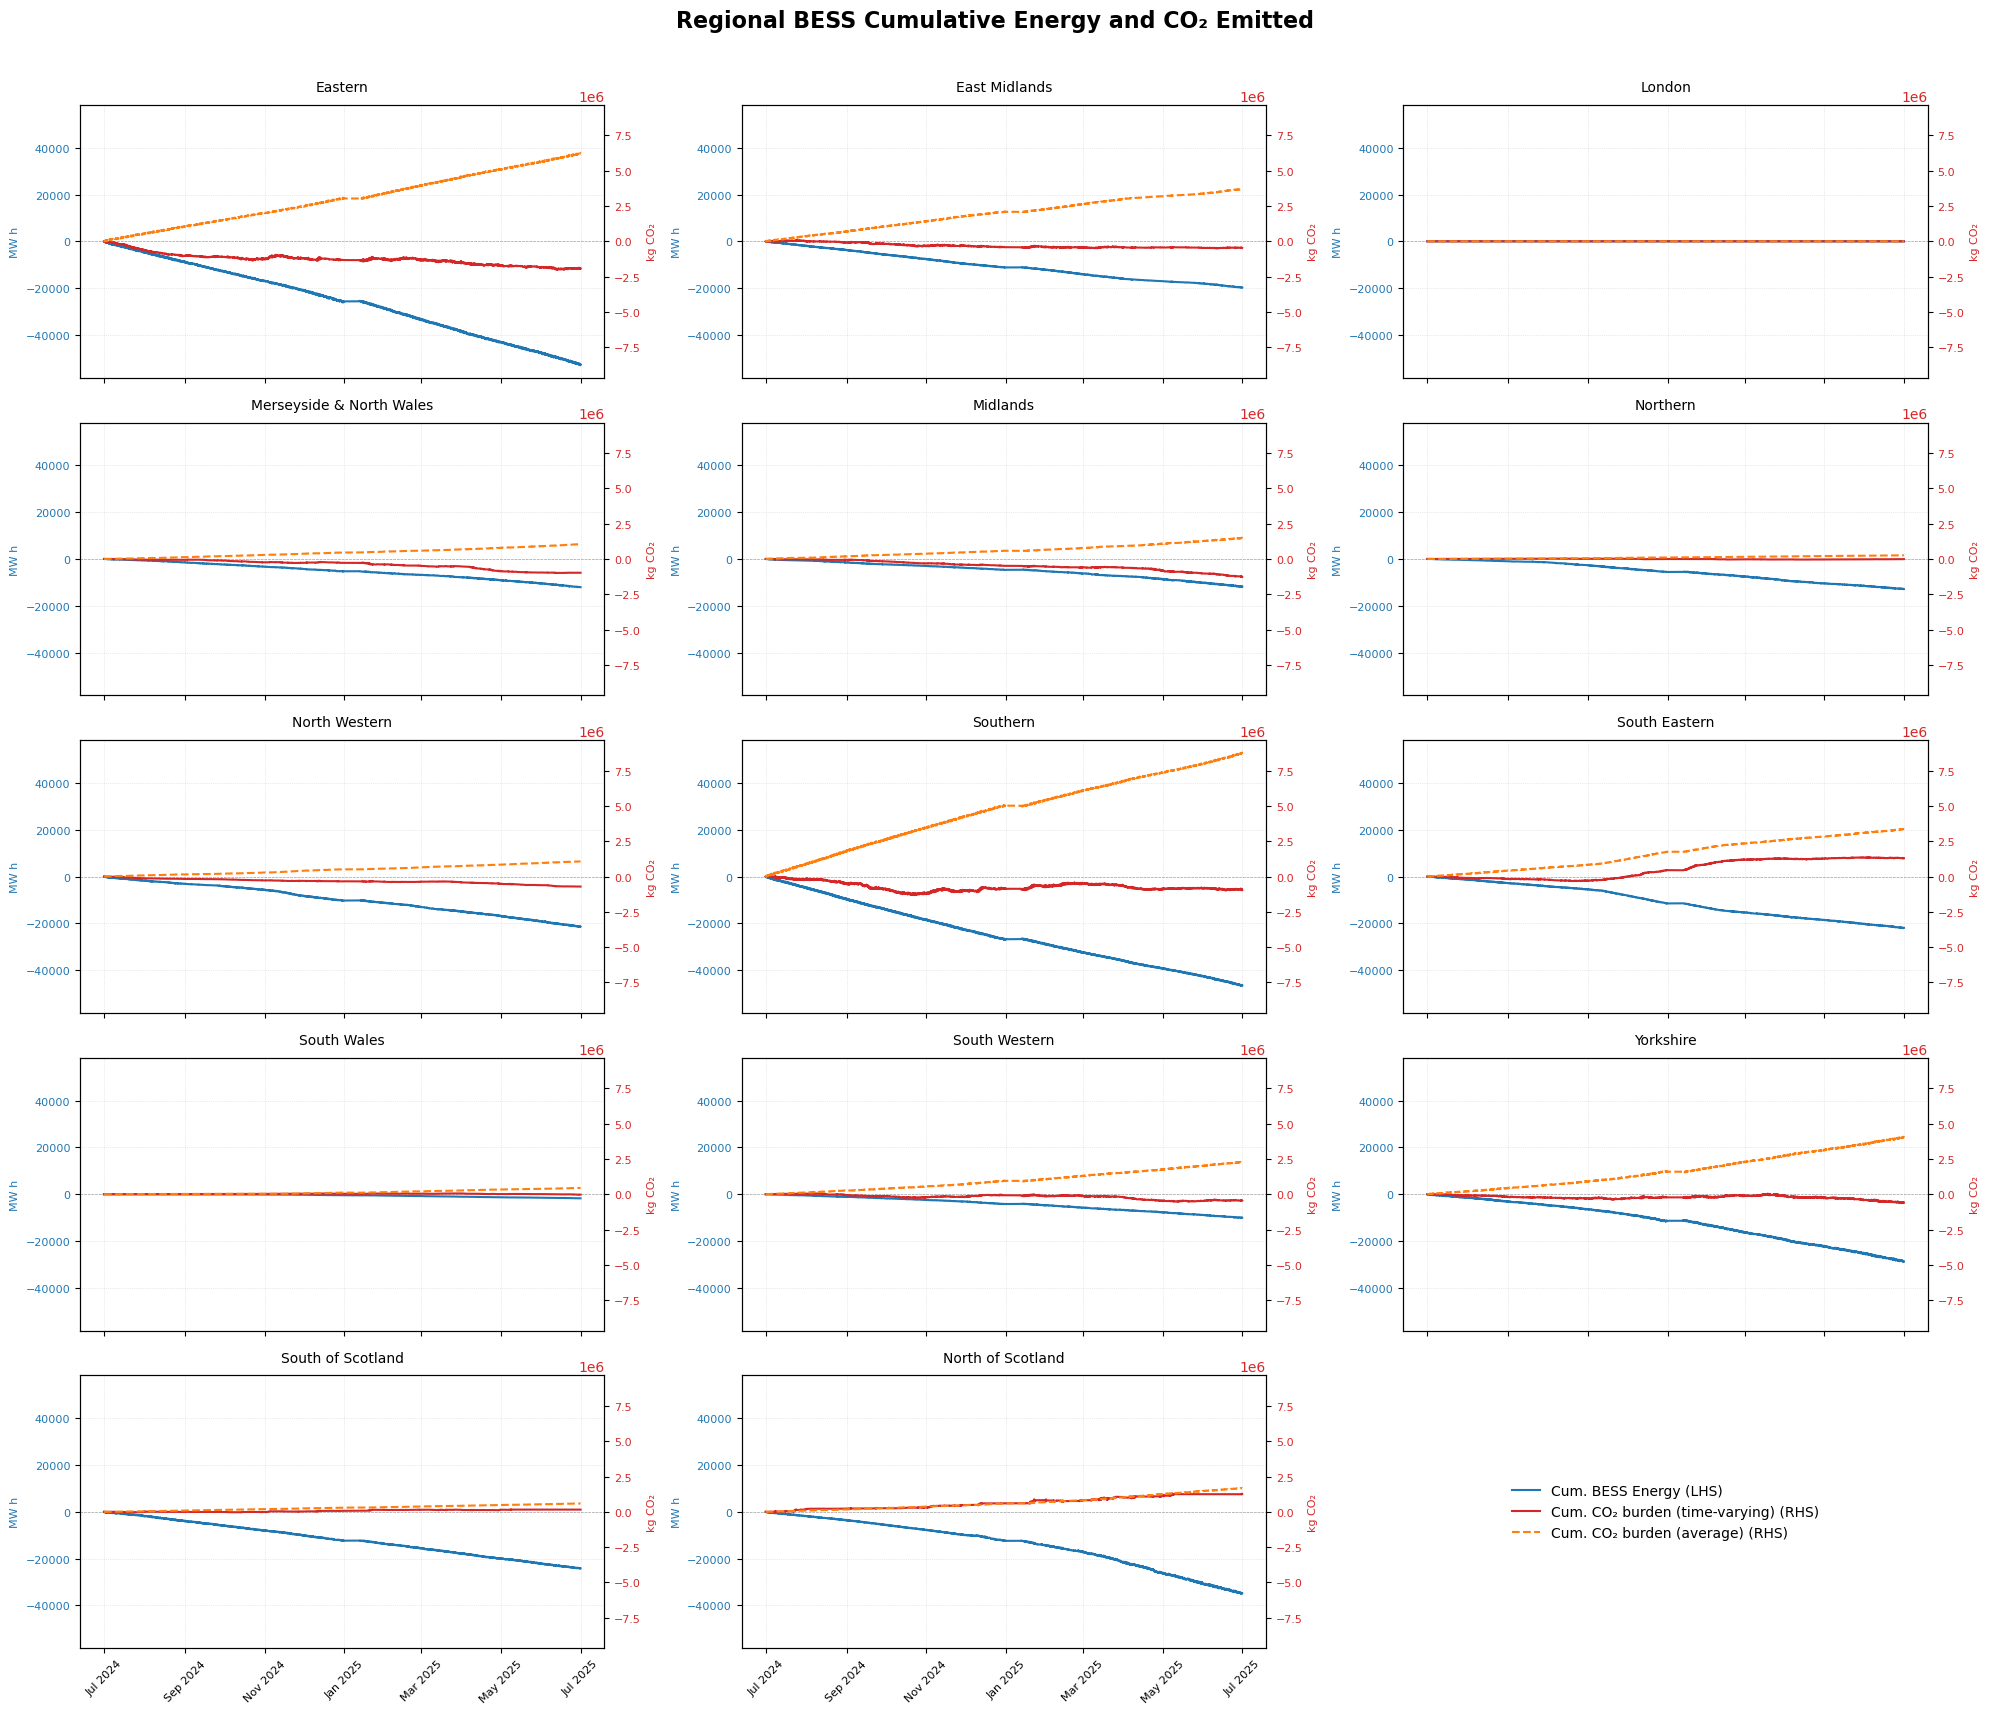

In [9]:
#This outputs 14 subplots of the regional data for cumulative energy and CO2. 
#Improvements to make - labelling of the plots - x and y axis. Also, can have cum energy and ave not flatline as data not missing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']

# === Prepare for axis scaling ===
global_energy_max = 0
global_co2_max = 0
region_data = {}

for region in regions:
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        continue

    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]
    region_df['Valid'] = region_df[ci_col].notna()
    region_df['NetEnergy_MWh'] = region_df['NetEnergy_MWh'].where(region_df['Valid'], 0)

    # Time-varying CO₂
    region_df['CO2_kg'] = region_df['NetEnergy_MWh'] * region_df[ci_col]
    region_df['CO2_kg'] = region_df['CO2_kg'].fillna(0)

    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()
    region_df['CumCO2'] = -region_df['CO2_kg'].cumsum()  # Flip sign

    # Average CO₂
    avg_ci = region_df[ci_col].mean()
    region_df['CO2_kg_avg'] = region_df['NetEnergy_MWh'] * avg_ci
    region_df['CumCO2_avg'] = -region_df['CO2_kg_avg'].cumsum()

    global_energy_max = max(global_energy_max, region_df['CumEnergy'].abs().max())
    global_co2_max = max(global_co2_max, region_df['CumCO2'].abs().max(), region_df['CumCO2_avg'].abs().max())

    region_data[region] = region_df

# === Set axis limits based on global maxes ===
energy_lim = (-global_energy_max * 1.1, global_energy_max * 1.1)
co2_lim = (-global_co2_max * 1.1, global_co2_max * 1.1)

# === Set up plot grid ===
fig, axes = plt.subplots(5, 3, figsize=(20, 18), sharex=True)
axes = axes.flatten()

# === Collect one copy of each line style for the global legend ===
legend_handles = []

for i, region in enumerate(regions):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    if region not in region_data:
        ax1.set_visible(False)
        continue

    region_df = region_data[region]

    # === Plot energy ===
    line1, = ax1.plot(region_df['datetime'], region_df['CumEnergy'],
                      color='tab:blue', linewidth=1.5)
    ax1.set_ylim(energy_lim)
    ax1.set_ylabel("MW h", color='tab:blue', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)

    # === Plot CO₂ burden (actual) ===
    line2, = ax2.plot(region_df['datetime'], region_df['CumCO2'],
                      color='tab:red', linewidth=1.5)

    # === Plot CO₂ burden (average) ===
    line3, = ax2.plot(region_df['datetime'], region_df['CumCO2_avg'],
                      color='tab:orange', linestyle='--', linewidth=1.5)

    ax2.set_ylim(co2_lim)
    ax2.set_ylabel("kg CO\u2082", color='tab:red', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=8)

    # === Formatting ===
    region_descriptions = {
        '_A': 'Eastern',
        '_B': 'East Midlands',
        '_C': 'London',
        '_D': 'Merseyside & North Wales',
        '_E': 'Midlands',
        '_F': 'Northern',
        '_G': 'North Western',
        '_H': 'Southern',
        '_J': 'South Eastern',
        '_K': 'South Wales',
        '_L': 'South Western',
        '_M': 'Yorkshire',
        '_N': 'South of Scotland',
        '_P': 'North of Scotland'
    }
    ax1.set_title(region_descriptions.get(region, region), fontsize=10, pad=10)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)
    ax1.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

    # Save first instance of legend handles
    if not legend_handles:
        legend_handles = [
            (line1, "Cum. BESS Energy (LHS)"),
            (line2, "Cum. CO₂ burden (time-varying) (RHS)"),
            (line3, "Cum. CO₂ burden (average) (RHS)")
        ]

# === Hide and use final subplot for legend ===
if len(regions) < len(axes):
    axes[-1].axis('off')
    handles, labels = zip(*legend_handles)
    axes[-1].legend(handles, labels, loc='center', fontsize=10, frameon=False)

# === Title and layout ===
fig.suptitle("Regional BESS Cumulative Energy and CO₂ Emitted", fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


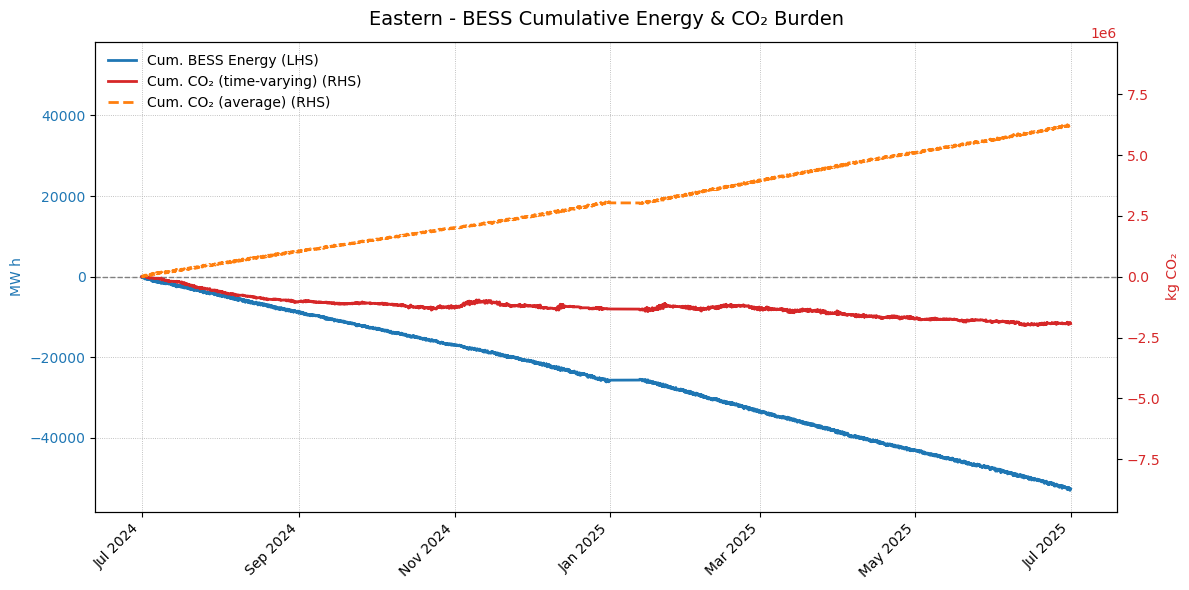

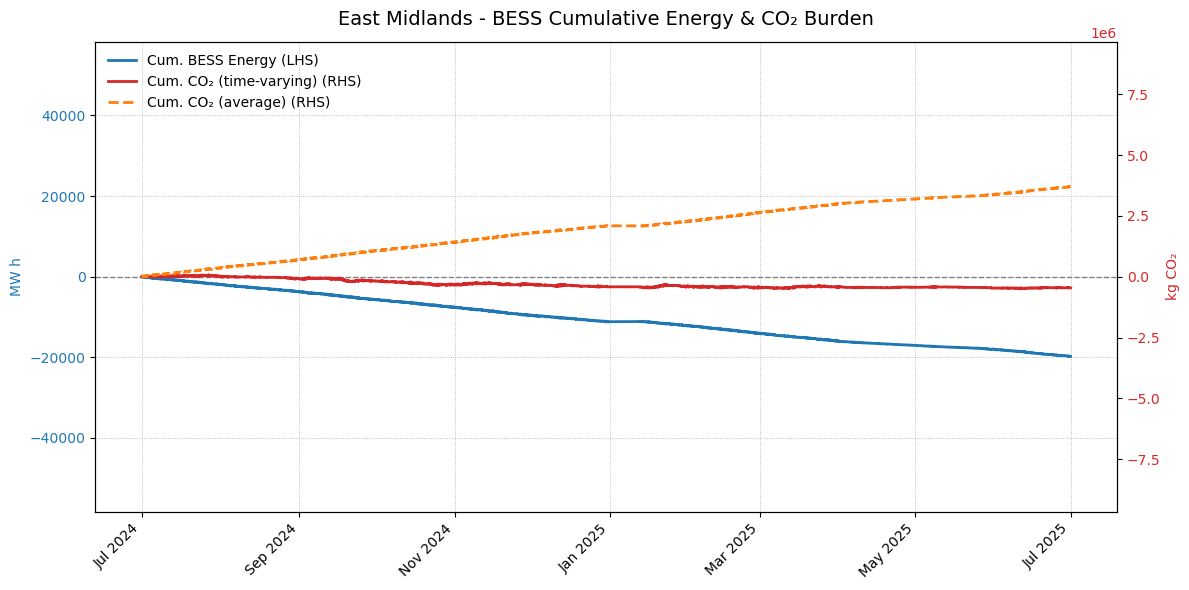

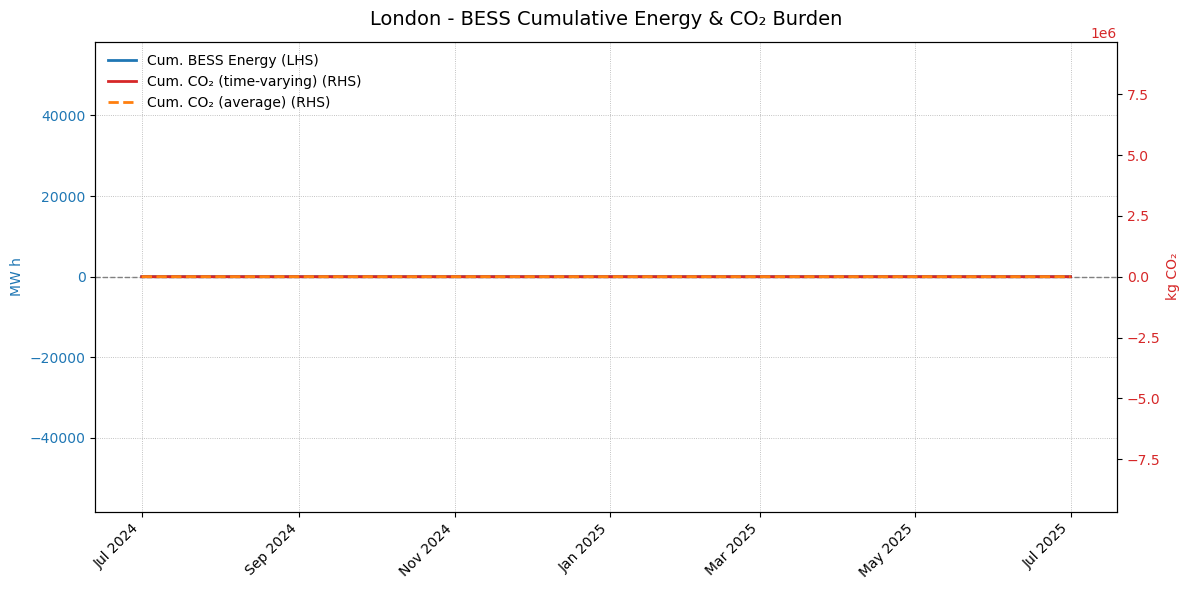

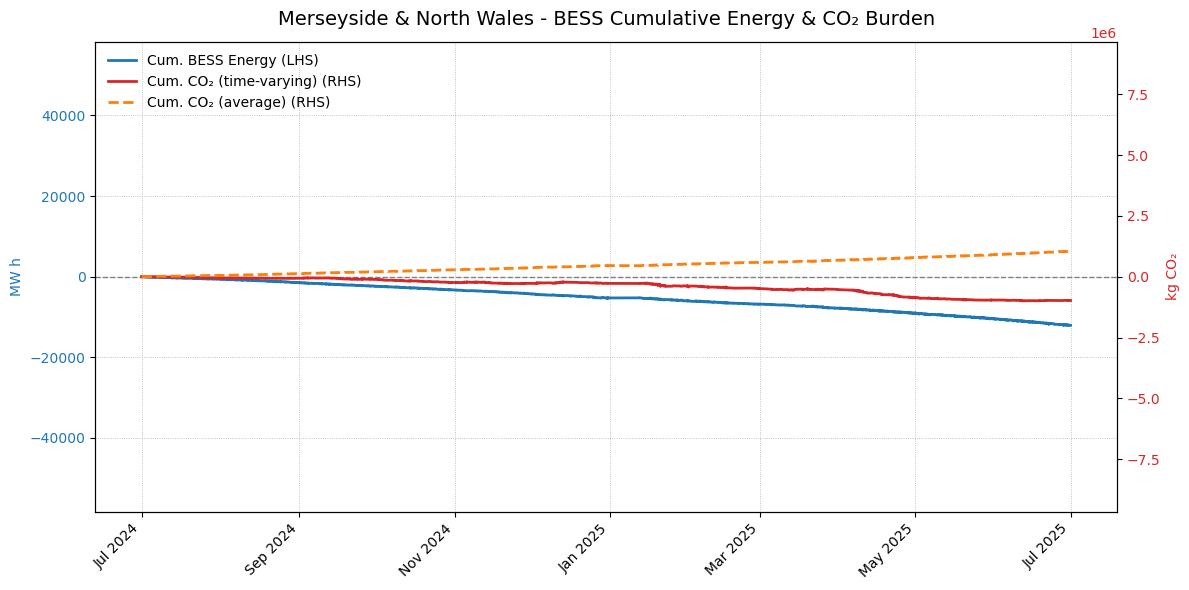

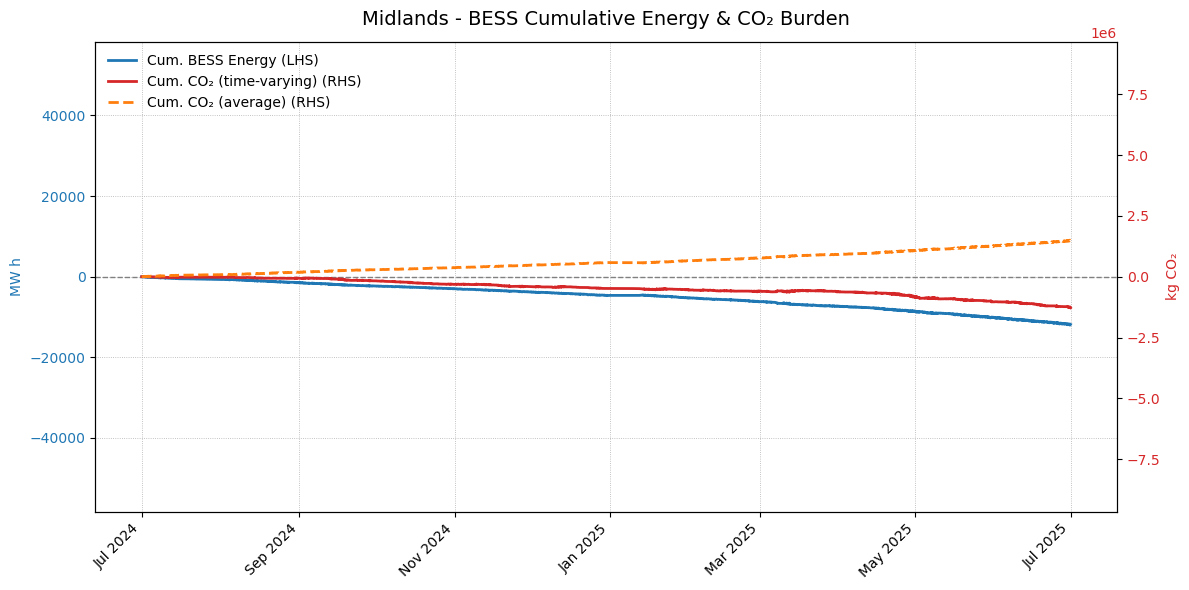

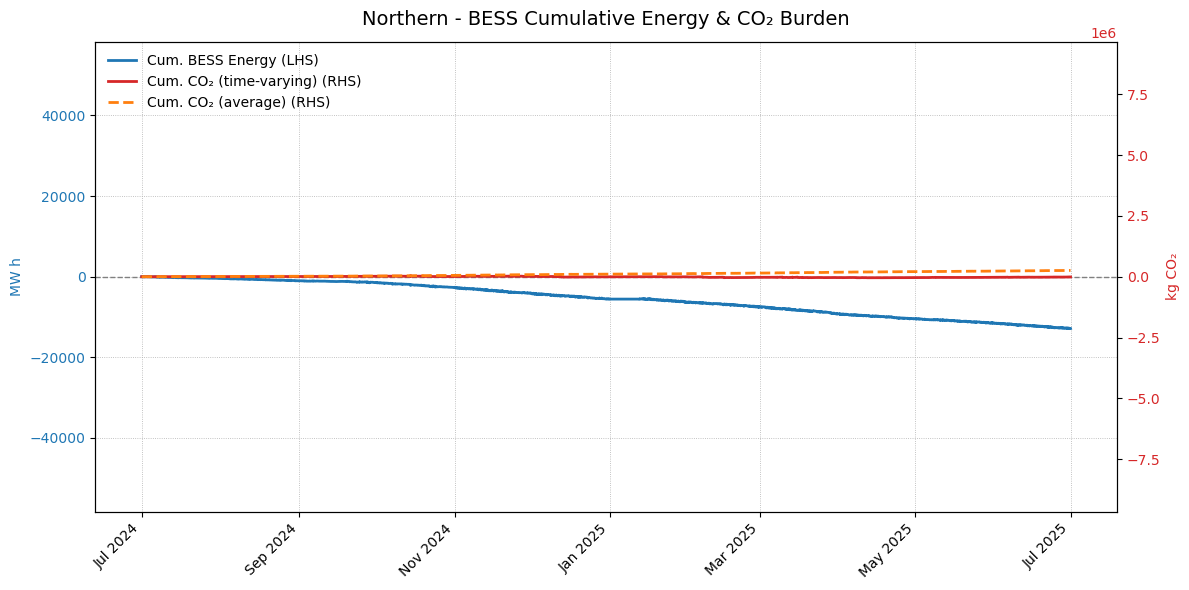

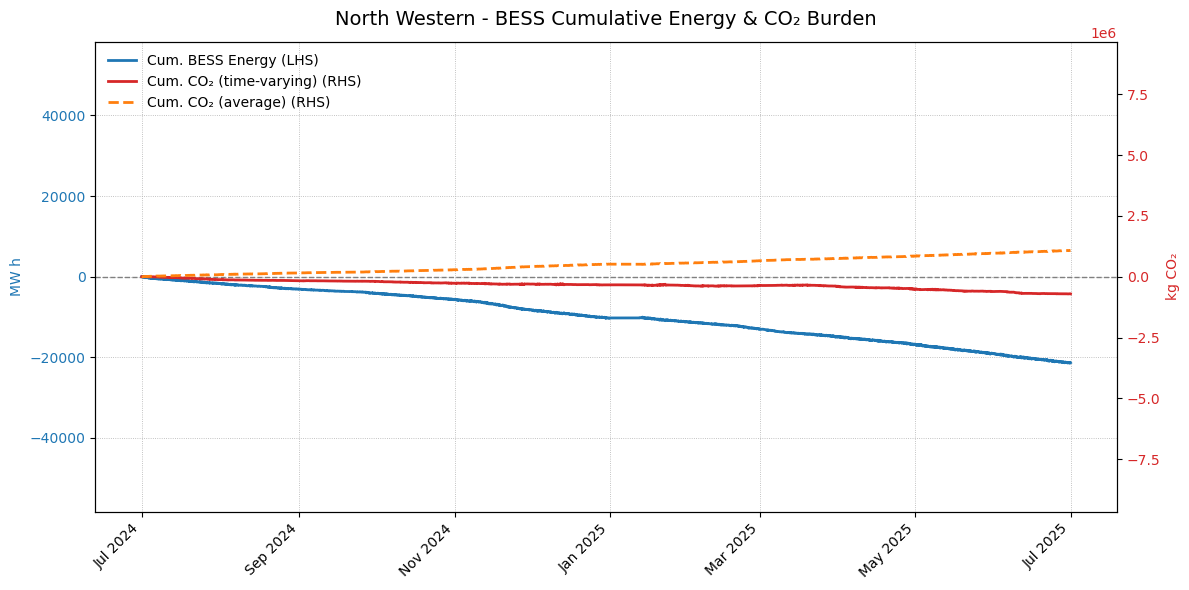

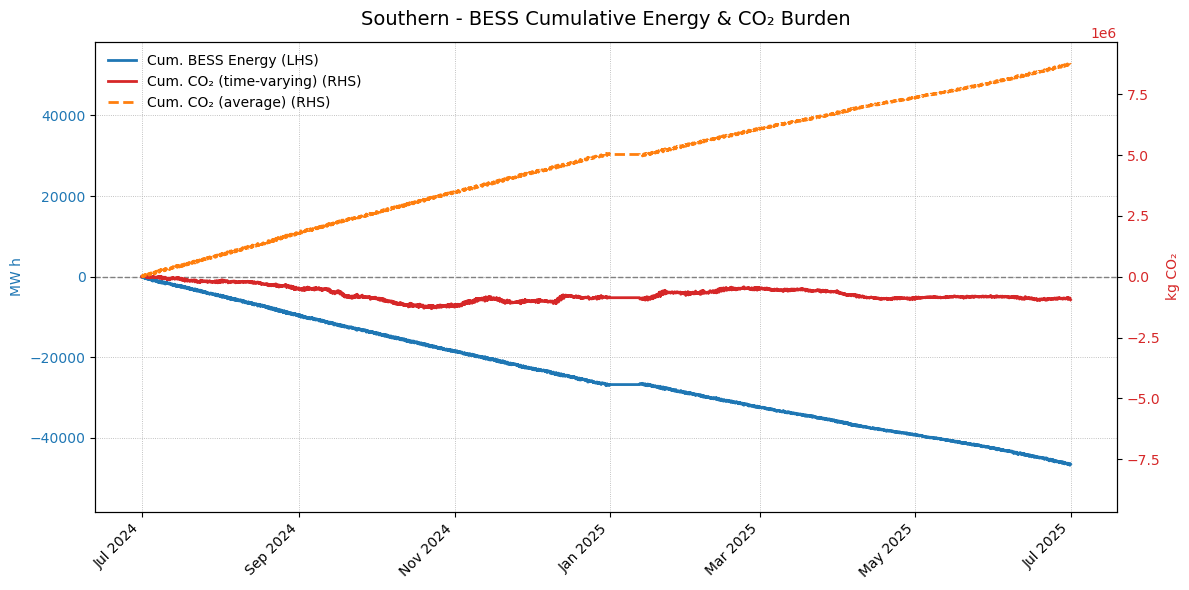

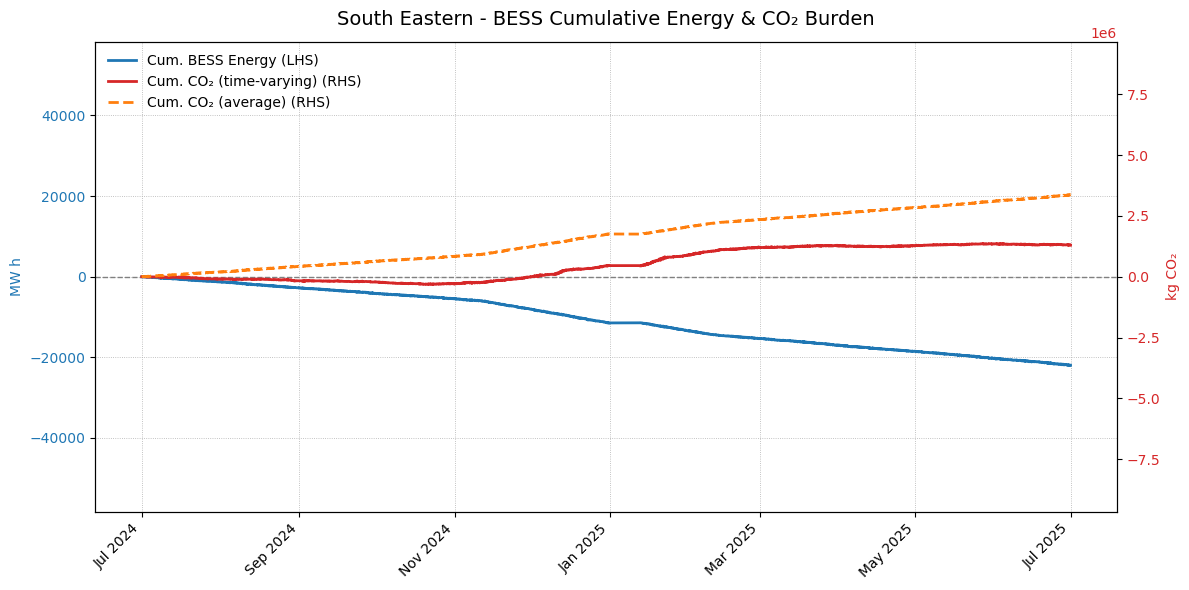

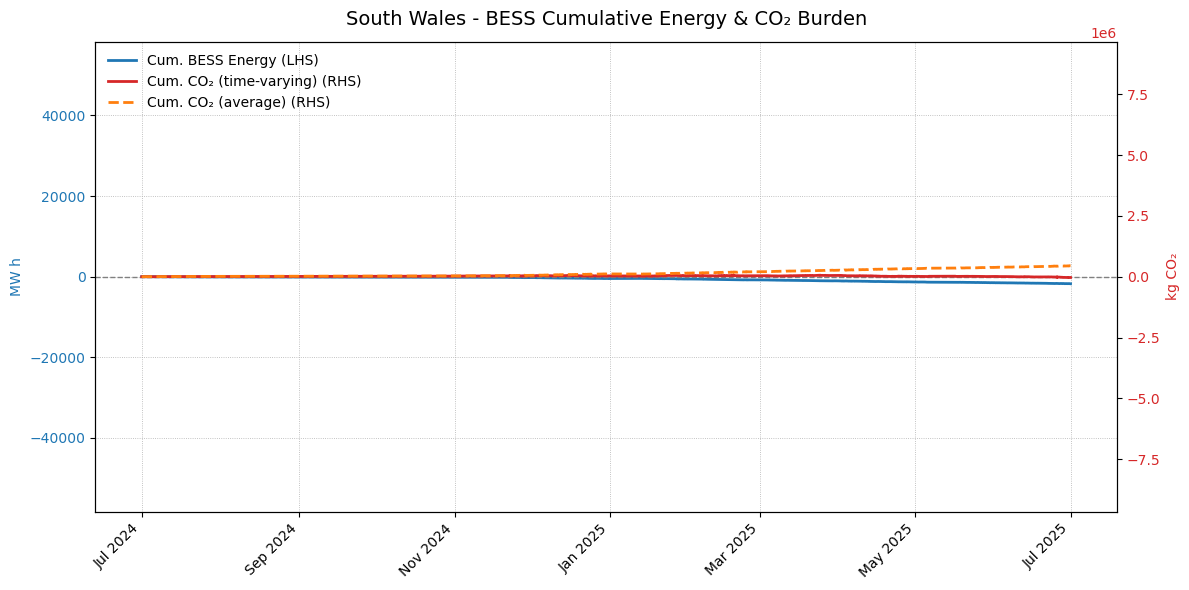

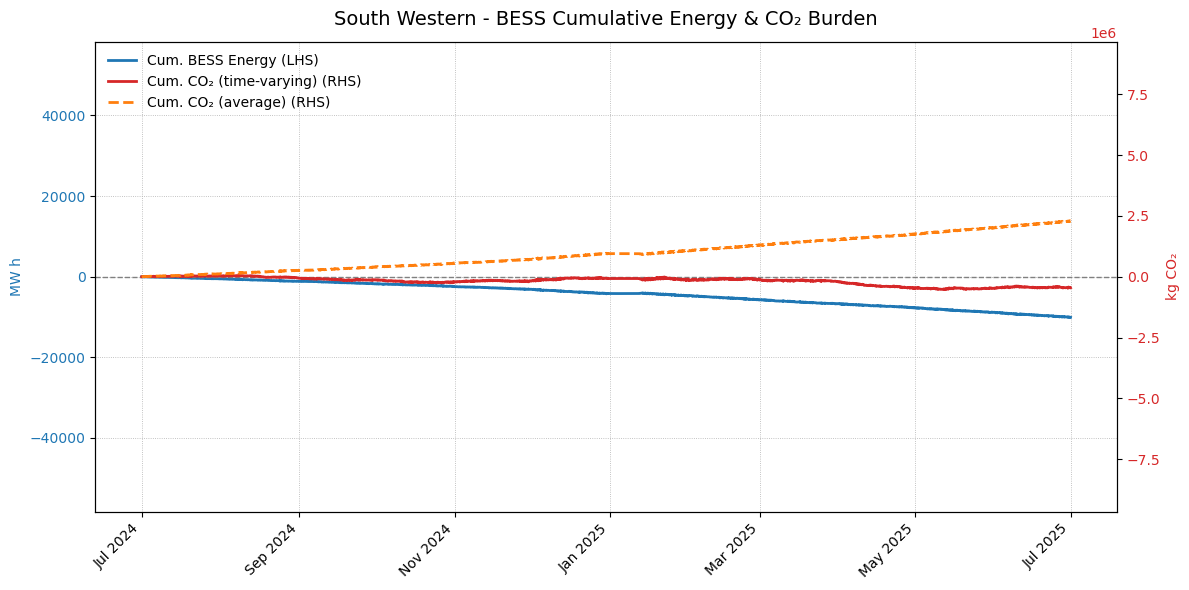

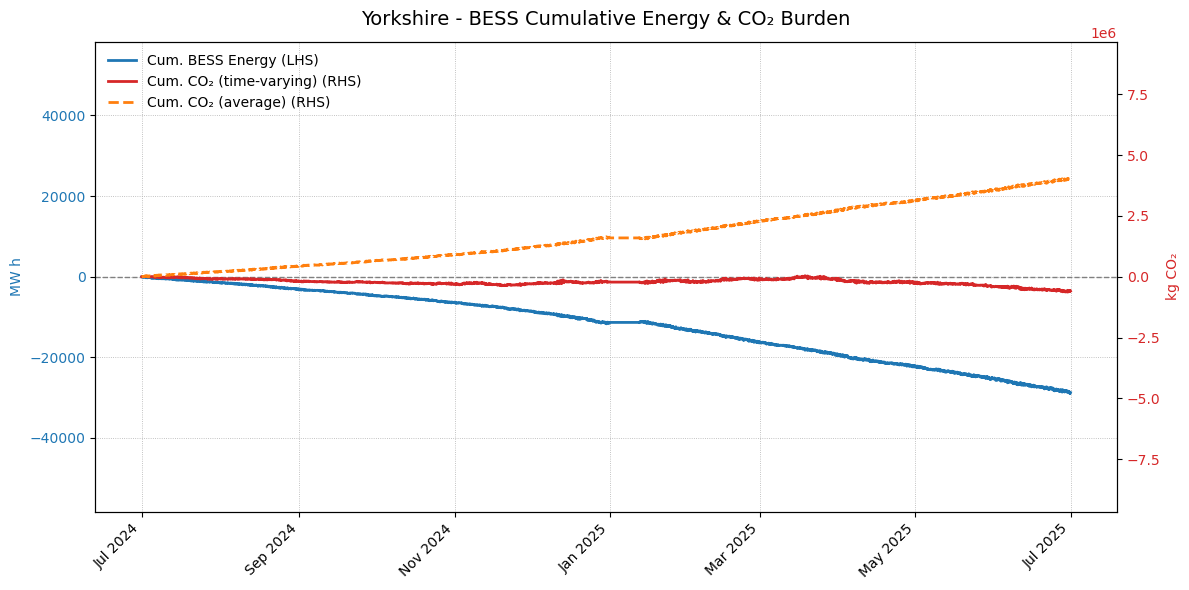

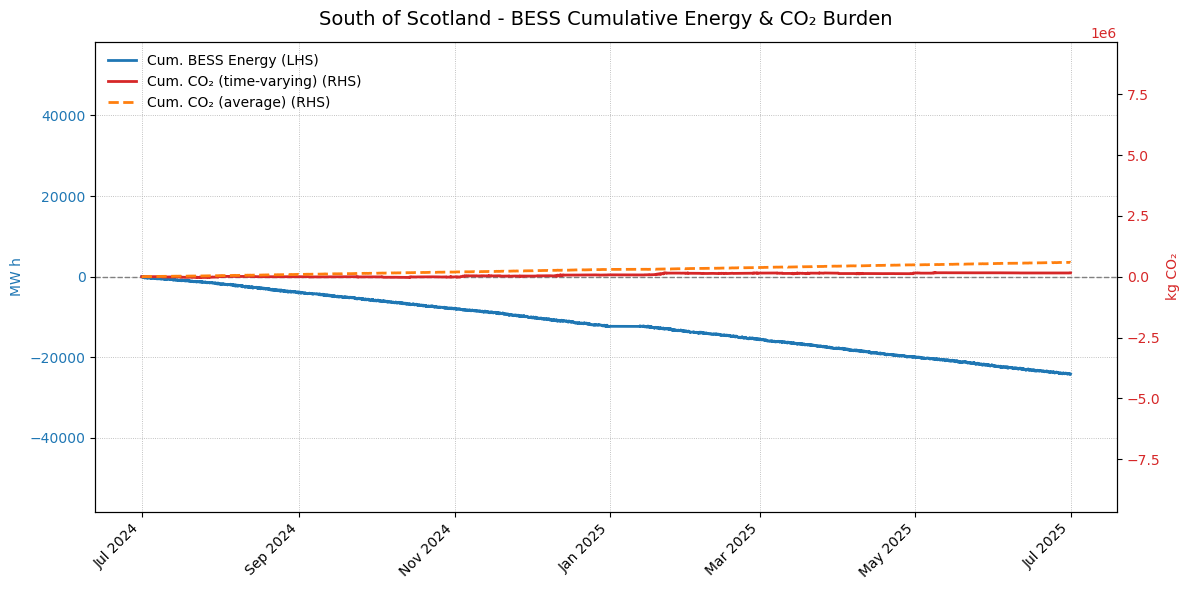

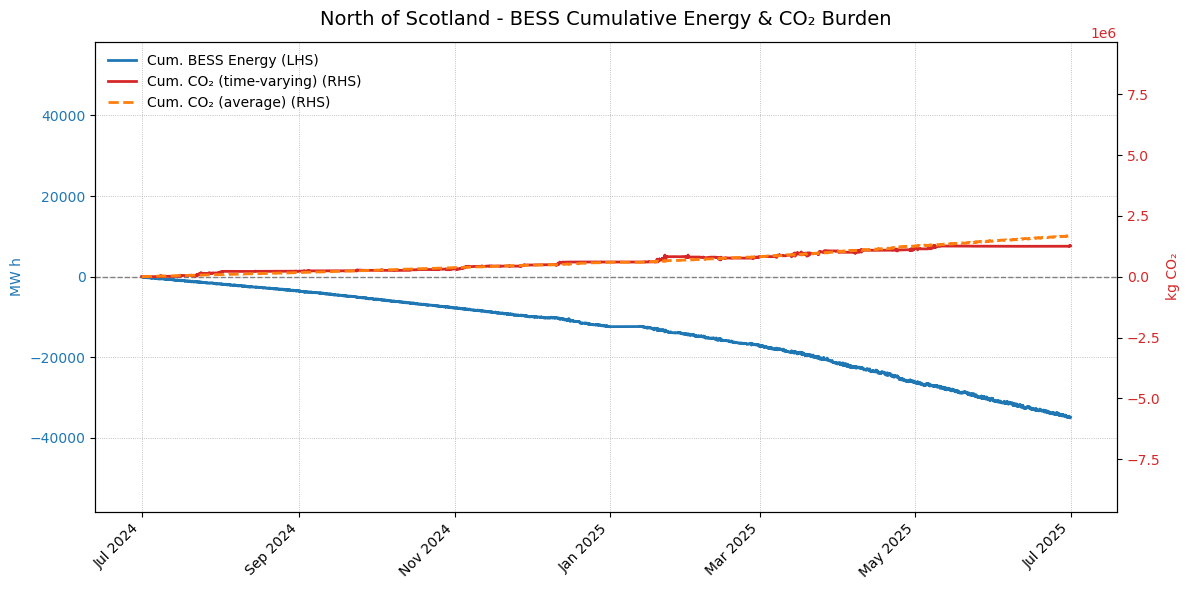


=== Summary Table ===
                  Region  Cum. BESS Energy (MW h)  Cum. CO2 (time-varying) (kg)  Cum. CO2 (average) (kg)
                 Eastern               -52570.078                  -1935700.111             6.221374e+06
           East Midlands               -19737.973                   -460299.384             3.702428e+06
                  London                    0.000                        -0.000            -0.000000e+00
Merseyside & North Wales               -12046.503                   -978007.005             1.045258e+06
                Midlands               -11826.699                  -1274120.923             1.480450e+06
                Northern               -12865.583                     -9418.725             2.587931e+05
           North Western               -21344.495                   -706093.945             1.077254e+06
                Southern               -46463.210                   -948678.971             8.728965e+06
           South Eastern        

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes and descriptions ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern',
    '_B': 'East Midlands',
    '_C': 'London',
    '_D': 'Merseyside & North Wales',
    '_E': 'Midlands',
    '_F': 'Northern',
    '_G': 'North Western',
    '_H': 'Southern',
    '_J': 'South Eastern',
    '_K': 'South Wales',
    '_L': 'South Western',
    '_M': 'Yorkshire',
    '_N': 'South of Scotland',
    '_P': 'North of Scotland'
}

# === Prepare for axis scaling and summary table ===
global_energy_max = 0
global_co2_max = 0
region_data = []
summary_data = []

# === Loop through regions to compute data and get axis bounds ===
for region in regions:
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        continue

    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]
    region_df['Valid'] = region_df[ci_col].notna()
    region_df['NetEnergy_MWh'] = region_df['NetEnergy_MWh'].where(region_df['Valid'], 0)

    # Time-varying CO₂
    region_df['CO2_kg'] = region_df['NetEnergy_MWh'] * region_df[ci_col]
    region_df['CO2_kg'] = region_df['CO2_kg'].fillna(0)

    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()
    region_df['CumCO2'] = -region_df['CO2_kg'].cumsum()

    # Average CO₂
    avg_ci = region_df[ci_col].mean()
    region_df['CO2_kg_avg'] = region_df['NetEnergy_MWh'] * avg_ci
    region_df['CumCO2_avg'] = -region_df['CO2_kg_avg'].cumsum()

    # Track axis bounds
    global_energy_max = max(global_energy_max, region_df['CumEnergy'].abs().max())
    global_co2_max = max(global_co2_max, region_df['CumCO2'].abs().max(), region_df['CumCO2_avg'].abs().max())

    # Add to summary
    final_row = region_df.iloc[-1]
    summary_data.append({
        "Region": region_descriptions.get(region, region),
        "Cum. BESS Energy (MW h)": final_row['CumEnergy'],
        "Cum. CO2 (time-varying) (kg)": final_row['CumCO2'],
        "Cum. CO2 (average) (kg)": final_row['CumCO2_avg']
    })

    # Store for plotting
    region_data.append((region_descriptions[region], region_df))

# === Axis limits ===
energy_lim = (-global_energy_max * 1.1, global_energy_max * 1.1)
co2_lim = (-global_co2_max * 1.1, global_co2_max * 1.1)

# === Plot individual charts ===
for name, region_df in region_data:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    # Plot Energy
    line1, = ax1.plot(region_df['datetime'], region_df['CumEnergy'], color='tab:blue', linewidth=2, label="Cum. BESS Energy (LHS)")
    ax1.set_ylabel("MW h", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(energy_lim)

    # Plot CO2 actual and average
    line2, = ax2.plot(region_df['datetime'], region_df['CumCO2'], color='tab:red', linewidth=2, label="Cum. CO₂ (time-varying) (RHS)")
    line3, = ax2.plot(region_df['datetime'], region_df['CumCO2_avg'], color='tab:orange', linestyle='--', linewidth=2, label="Cum. CO₂ (average) (RHS)")
    ax2.set_ylabel("kg CO\u2082", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(co2_lim)

    # Format
    ax1.set_title(f"{name} - BESS Cumulative Energy & CO₂ Burden", fontsize=14, pad=12)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax1.grid(True, linestyle=':', linewidth=0.6)

    # Legend
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10, frameon=False)

    plt.tight_layout()
    plt.show()

    # Optionally save:
    # fig.savefig(f"{name.replace(' ', '_')}_BESS_CO2.png", dpi=300)

# === Output summary table ===
summary_df = pd.DataFrame(summary_data)
totals = summary_df.drop(columns="Region").sum(numeric_only=True)
totals["Region"] = "TOTAL"
summary_df = pd.concat([summary_df, pd.DataFrame([totals])], ignore_index=True)

print("\n=== Summary Table ===")
print(summary_df.to_string(index=False))


In [8]:
summary_df.to_csv(r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\regional_bess_summary.csv", index=False)

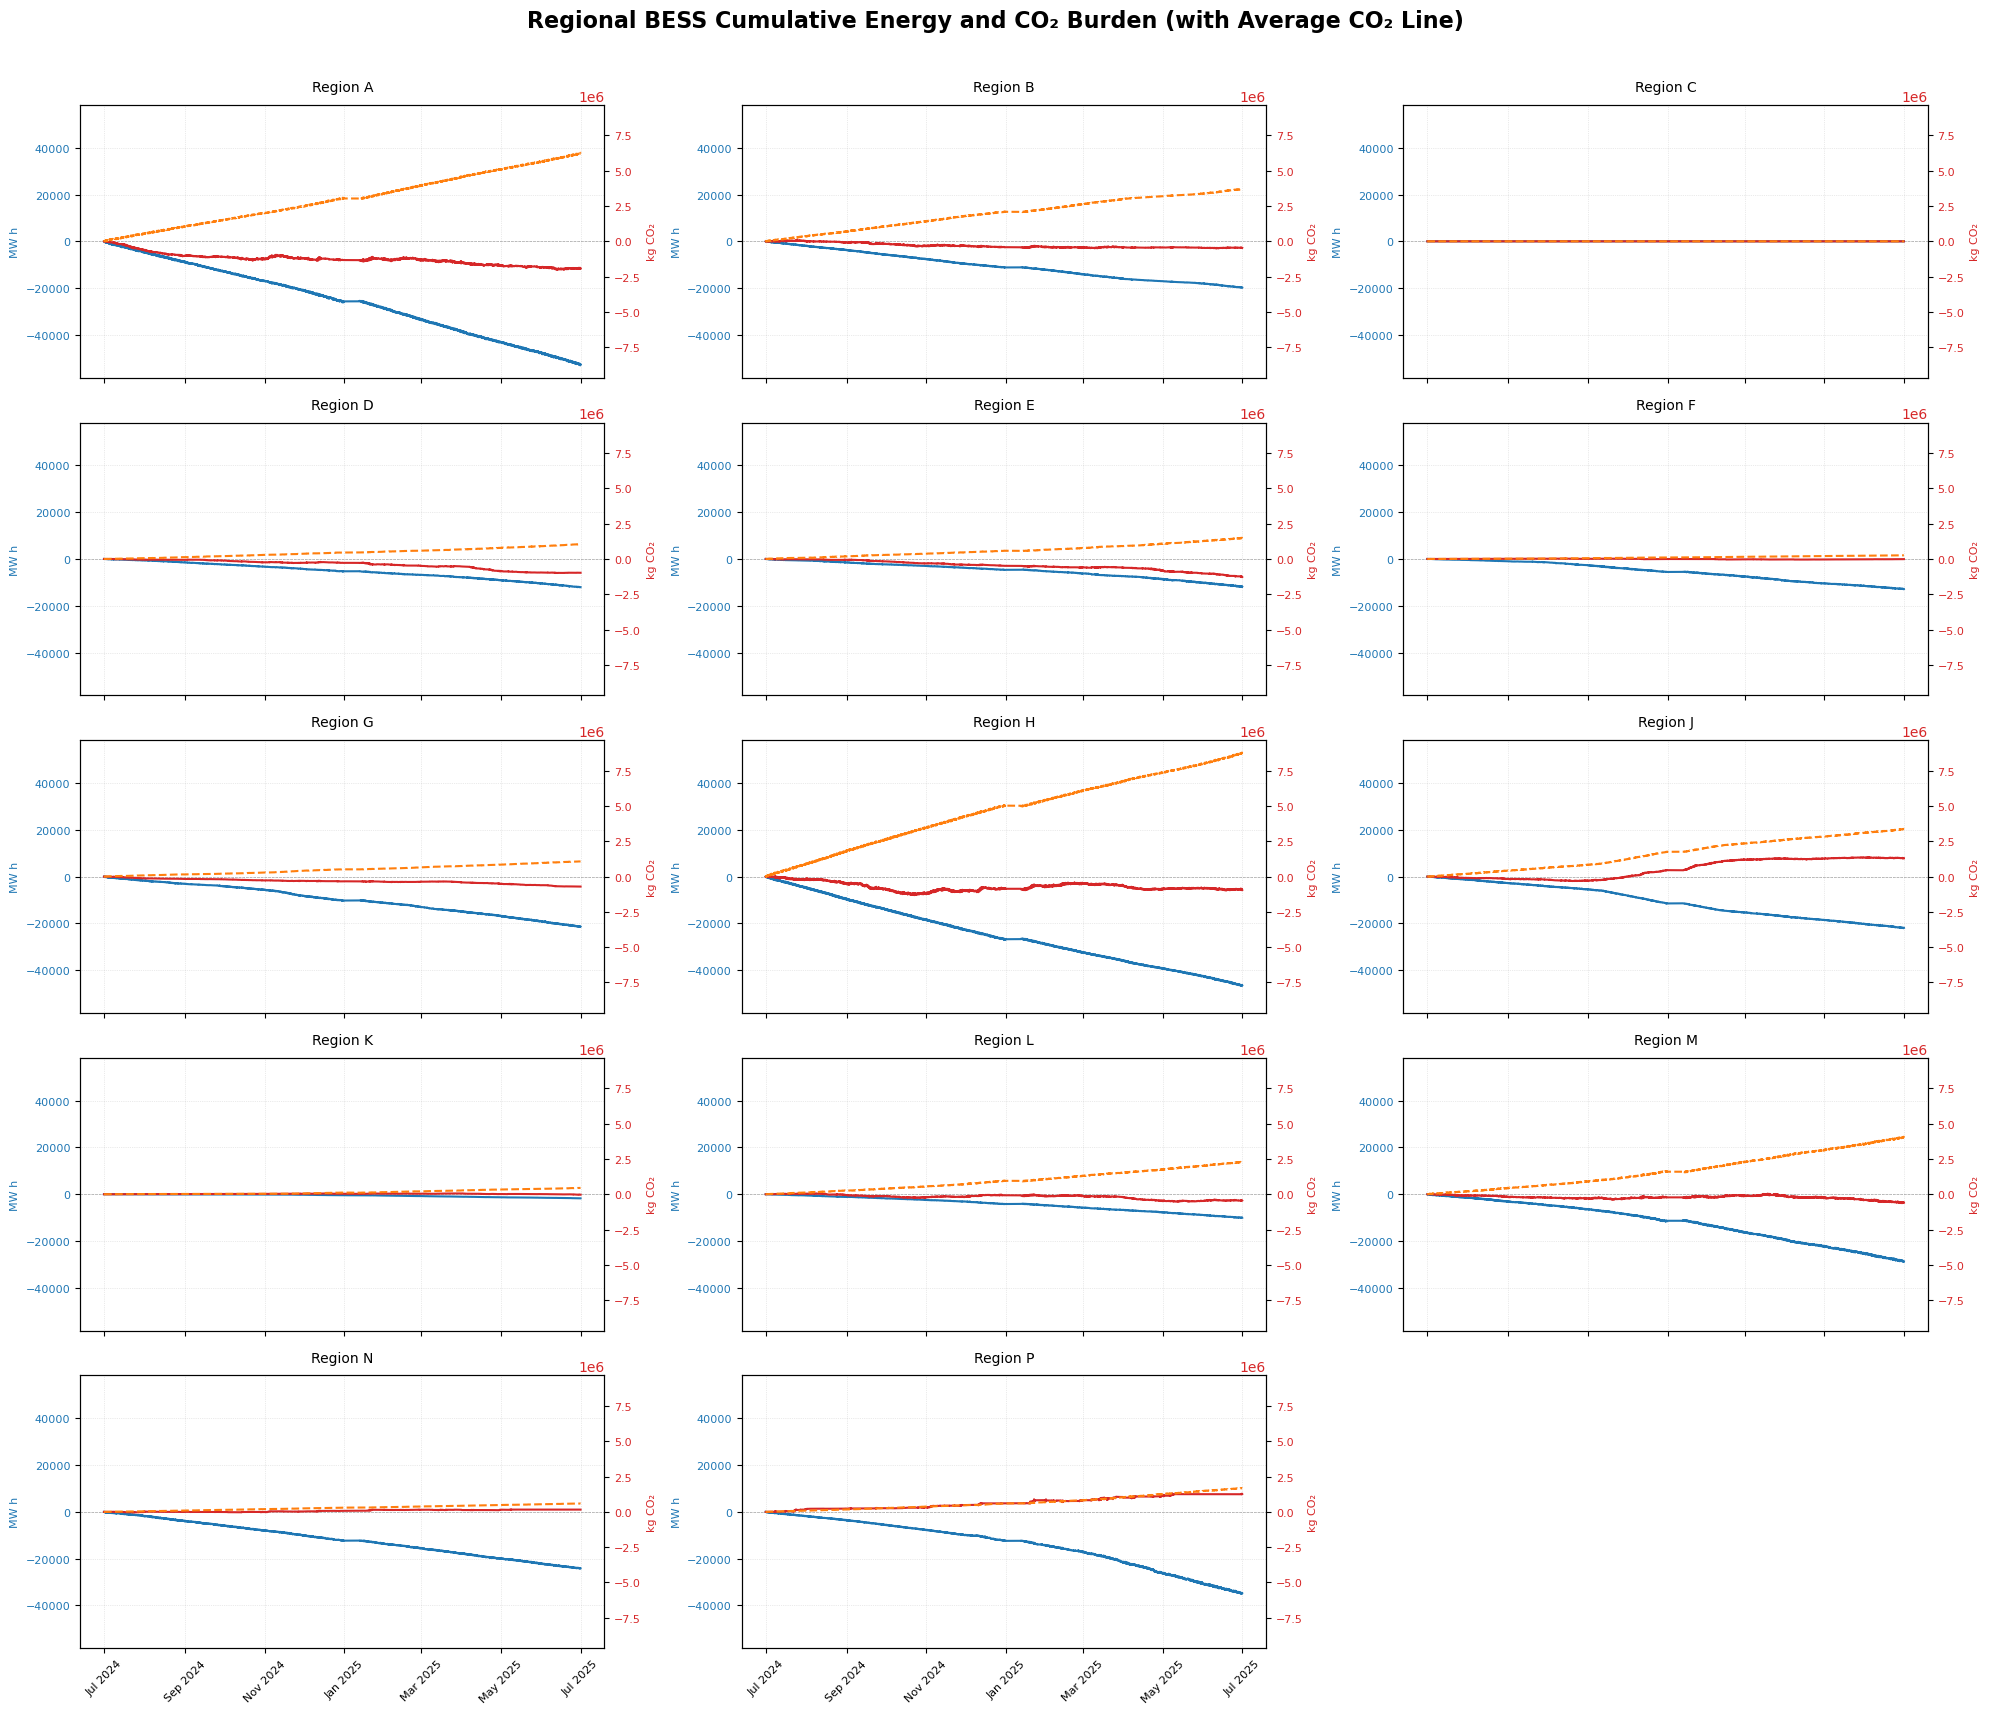

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']

# === Prepare for axis scaling ===
global_energy_max = 0
global_co2_max = 0
region_data = {}

for region in regions:
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        continue

    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]
    region_df['Valid'] = region_df[ci_col].notna()
    region_df['NetEnergy_MWh'] = region_df['NetEnergy_MWh'].where(region_df['Valid'], 0)

    # Time-varying CO₂
    region_df['CO2_kg'] = region_df['NetEnergy_MWh'] * region_df[ci_col]
    region_df['CO2_kg'] = region_df['CO2_kg'].fillna(0)

    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()
    region_df['CumCO2'] = -region_df['CO2_kg'].cumsum()  # Flipped sign

    # Average CO₂
    avg_ci = region_df[ci_col].mean()
    region_df['CO2_kg_avg'] = region_df['NetEnergy_MWh'] * avg_ci
    region_df['CumCO2_avg'] = -region_df['CO2_kg_avg'].cumsum()

    # Track global max values for axis scaling
    global_energy_max = max(global_energy_max, region_df['CumEnergy'].abs().max())
    global_co2_max = max(global_co2_max, region_df['CumCO2'].abs().max(), region_df['CumCO2_avg'].abs().max())

    region_data[region] = region_df

# === Set axis limits based on global maxes ===
energy_lim = (-global_energy_max * 1.1, global_energy_max * 1.1)
co2_lim = (-global_co2_max * 1.1, global_co2_max * 1.1)

# === Plotting setup ===
fig, axes = plt.subplots(5, 3, figsize=(20, 18), sharex=True)
axes = axes.flatten()

for i, region in enumerate(regions):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    if region not in region_data:
        ax1.set_visible(False)
        continue

    region_df = region_data[region]

    # === Plot energy ===
    ax1.plot(region_df['datetime'], region_df['CumEnergy'], color='tab:blue', linewidth=1.5)
    ax1.set_ylim(energy_lim)
    ax1.set_ylabel("MW h", color='tab:blue', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)

    # === Plot CO₂ burden (actual) ===
    ax2.plot(region_df['datetime'], region_df['CumCO2'], color='tab:red', linewidth=1.5,
             label='Time-varying CO₂')
    
    # === Plot CO₂ burden (average) ===
    ax2.plot(region_df['datetime'], region_df['CumCO2_avg'], color='tab:orange', linestyle='--', linewidth=1.5,
             label='Average CO₂')

    ax2.set_ylim(co2_lim)
    ax2.set_ylabel("kg CO\u2082", color='tab:red', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=8)

    # === Formatting ===
    ax1.set_title(f"Region {region[-1]}", fontsize=10, pad=10)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)
    ax1.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

# === Hide last empty subplot ===
if len(regions) < len(axes):
    axes[-1].axis('off')

# === Title and layout ===
fig.suptitle("Regional BESS Cumulative Energy and CO₂ Burden (with Average CO₂ Line)", fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


C:\Users\spice\AppData\Local\Temp\ipykernel_28964\1990583277.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(energy_lim)
C:\Users\spice\AppData\Local\Temp\ipykernel_28964\1990583277.py:64: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(co2_lim)


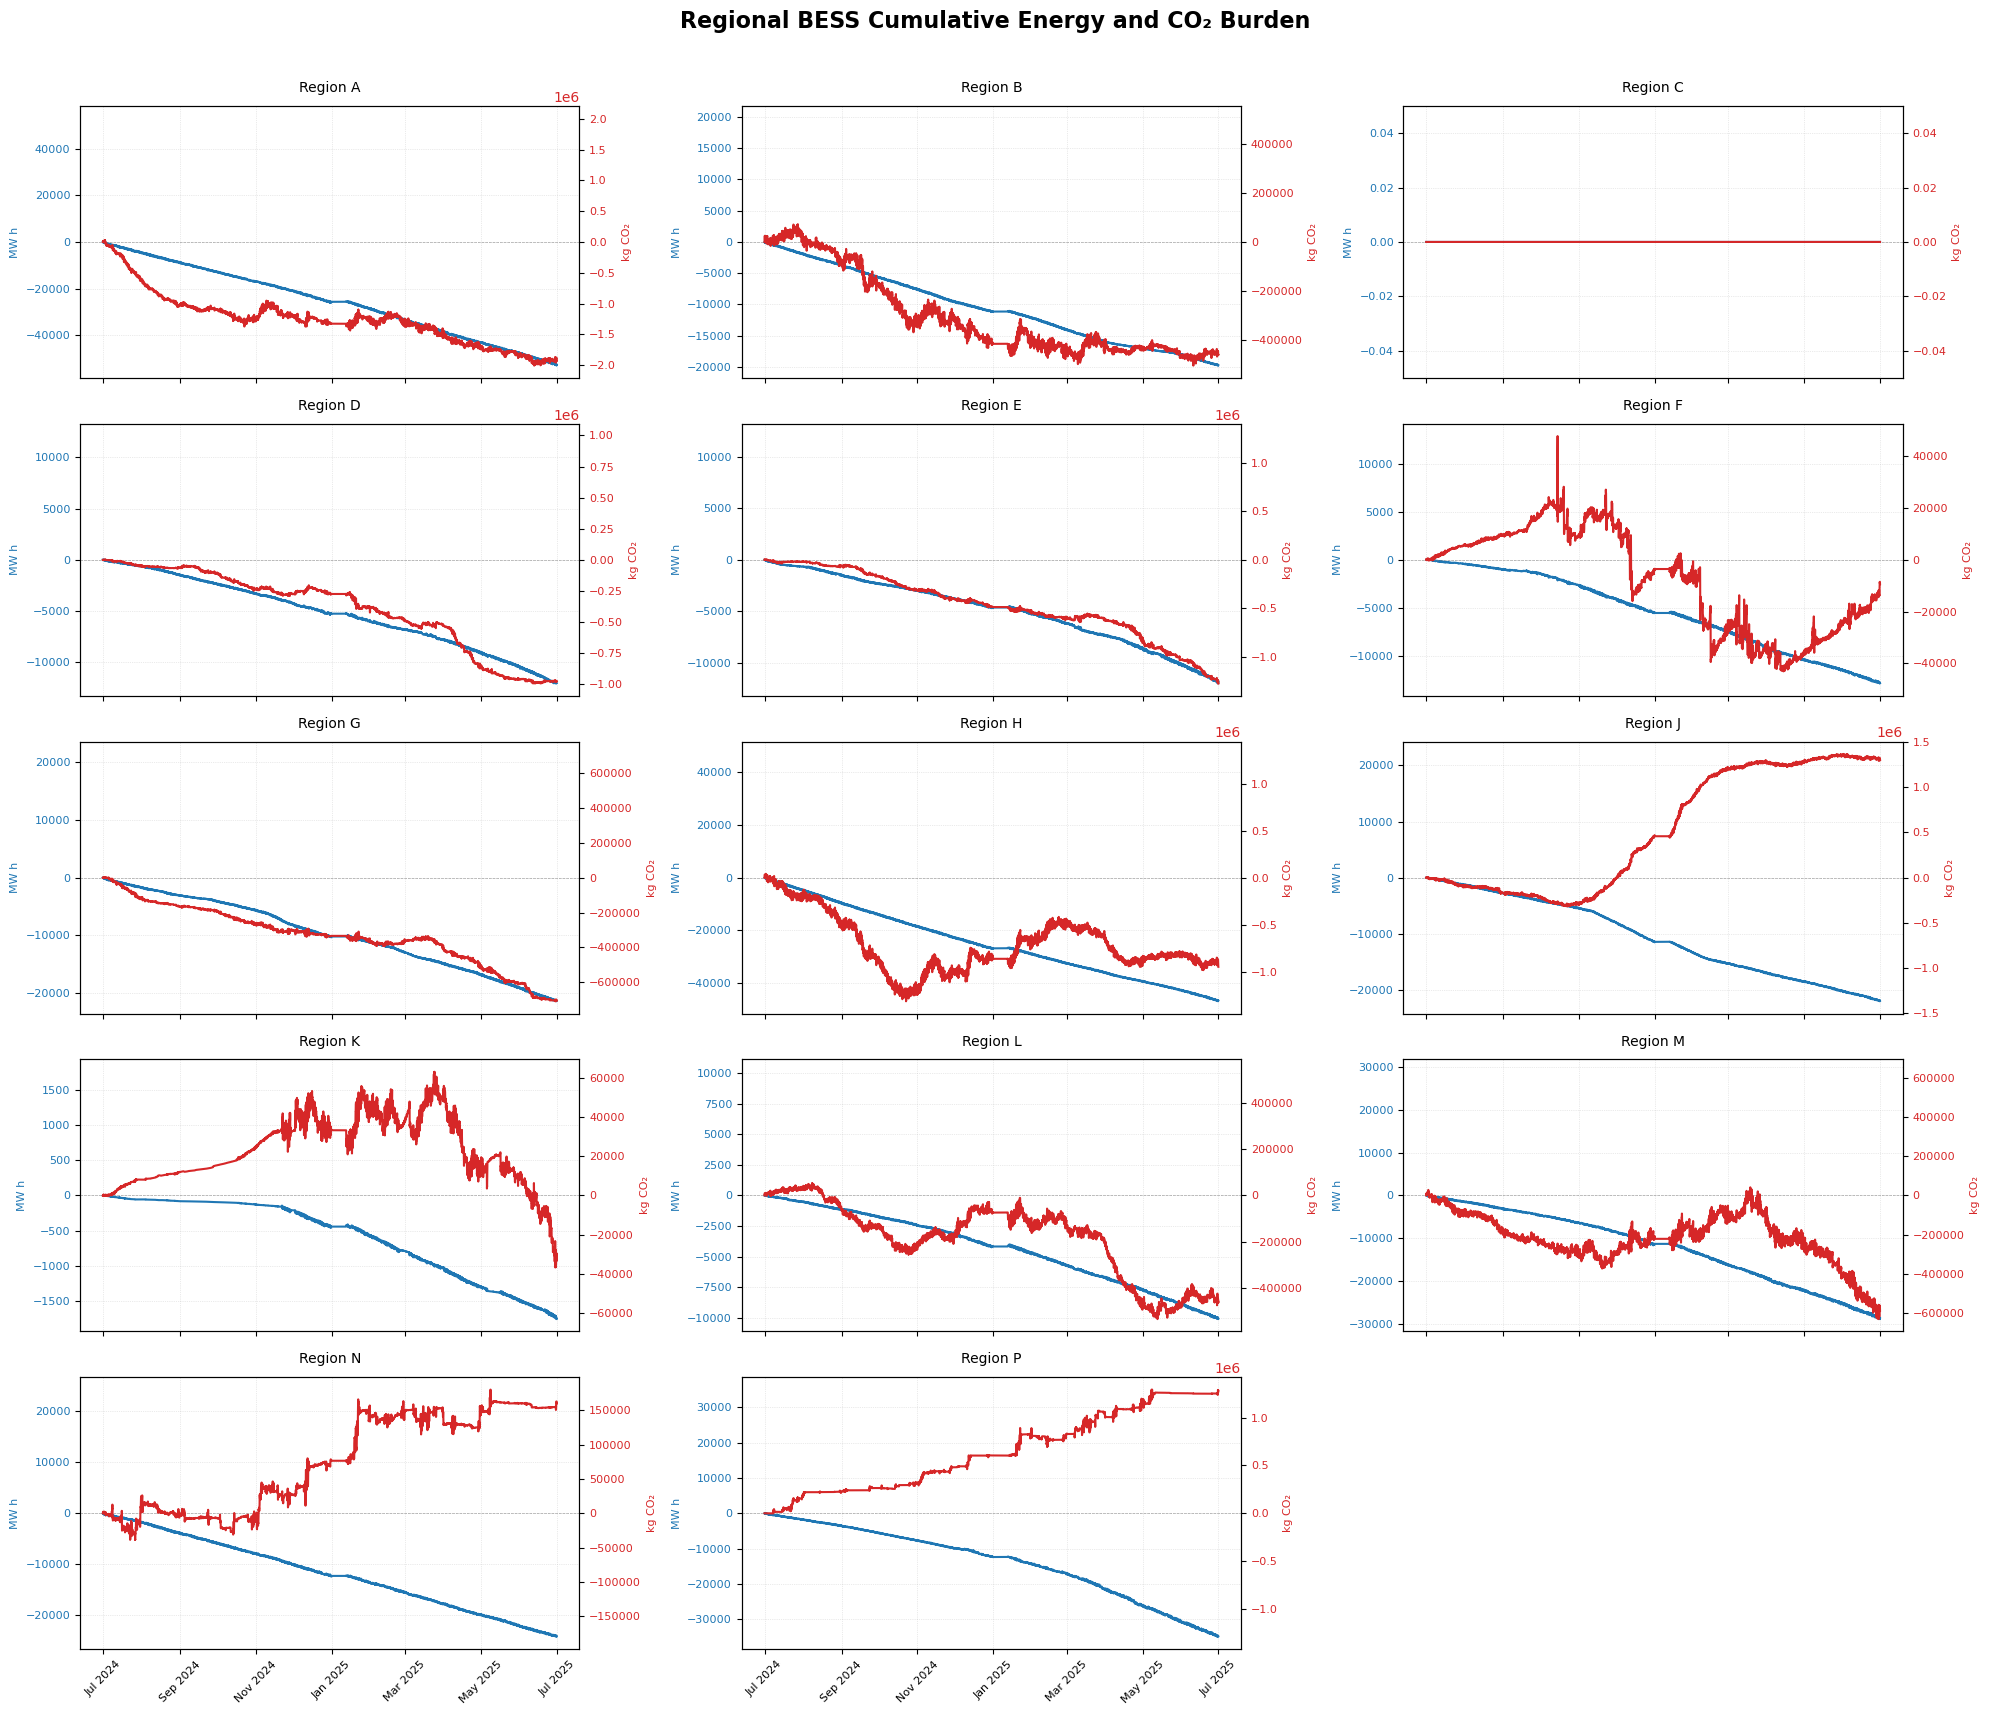

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes ===
regions = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']

# === Set up 5x3 plot grid ===
fig, axes = plt.subplots(5, 3, figsize=(20, 18), sharex=True)
axes = axes.flatten()

# === Loop through each region ===
for i, region in enumerate(regions):
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # Define column names
    charge_col = f'BESSCharge{region}'
    discharge_col = f'BESSDischarge{region}'
    ci_col = f'CarbonIntensityForecast{region}'

    # Skip if required columns are missing
    if not all(col in df.columns for col in [charge_col, discharge_col, ci_col]):
        ax1.set_visible(False)
        continue

    # === Compute net energy and CO2 ===
    region_df = df[['datetime', charge_col, discharge_col, ci_col]].copy()
    region_df['NetEnergy_MWh'] = region_df[charge_col] + region_df[discharge_col]

    # Where carbon intensity is NaN, energy & CO2 should not accumulate
    region_df['Valid'] = region_df[ci_col].notna()
    region_df['NetEnergy_MWh'] = region_df['NetEnergy_MWh'].where(region_df['Valid'], 0)
    region_df['CO2_kg'] = region_df['NetEnergy_MWh'] * region_df[ci_col]
    region_df['CO2_kg'] = region_df['CO2_kg'].fillna(0)

    region_df['CumEnergy'] = region_df['NetEnergy_MWh'].cumsum()
    region_df['CumCO2'] = -region_df['CO2_kg'].cumsum()  # Flip sign

    # === Determine axis ranges ===
    energy_max = region_df['CumEnergy'].abs().max()
    co2_max = region_df['CumCO2'].abs().max()
    energy_lim = (-energy_max * 1.1, energy_max * 1.1)
    co2_lim = (-co2_max * 1.1, co2_max * 1.1)

    # === Plot energy ===
    ax1.plot(region_df['datetime'], region_df['CumEnergy'], color='tab:blue', linewidth=1.5)
    ax1.set_ylim(energy_lim)
    ax1.set_ylabel("MW h", color='tab:blue', fontsize=8)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)

    # === Plot CO₂ ===
    ax2.plot(region_df['datetime'], region_df['CumCO2'], color='tab:red', linewidth=1.5)
    ax2.set_ylim(co2_lim)
    ax2.set_ylabel("kg CO\u2082", color='tab:red', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=8)

    # === Labels, grid, formatting ===
    ax1.set_title(f"Region {region[-1]}", fontsize=10, pad=10)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)
    ax1.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

# === Hide last empty subplot ===
if len(regions) < len(axes):
    axes[-1].axis('off')

# === Title and layout ===
fig.suptitle("Regional BESS Cumulative Energy and CO₂ Burden", fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
